[Cloud Composer: Copying BigQuery Tables Across Different Locations](https://www.cloudskillsboost.google/focuses/3528?catalog_rank=%7B%22rank%22%3A1%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=23700055)

In [ ]:
# https://cloud.google.com/blog/products/data-analytics/how-to-transfer-bigquery-tables-between-locations-with-cloud-composer

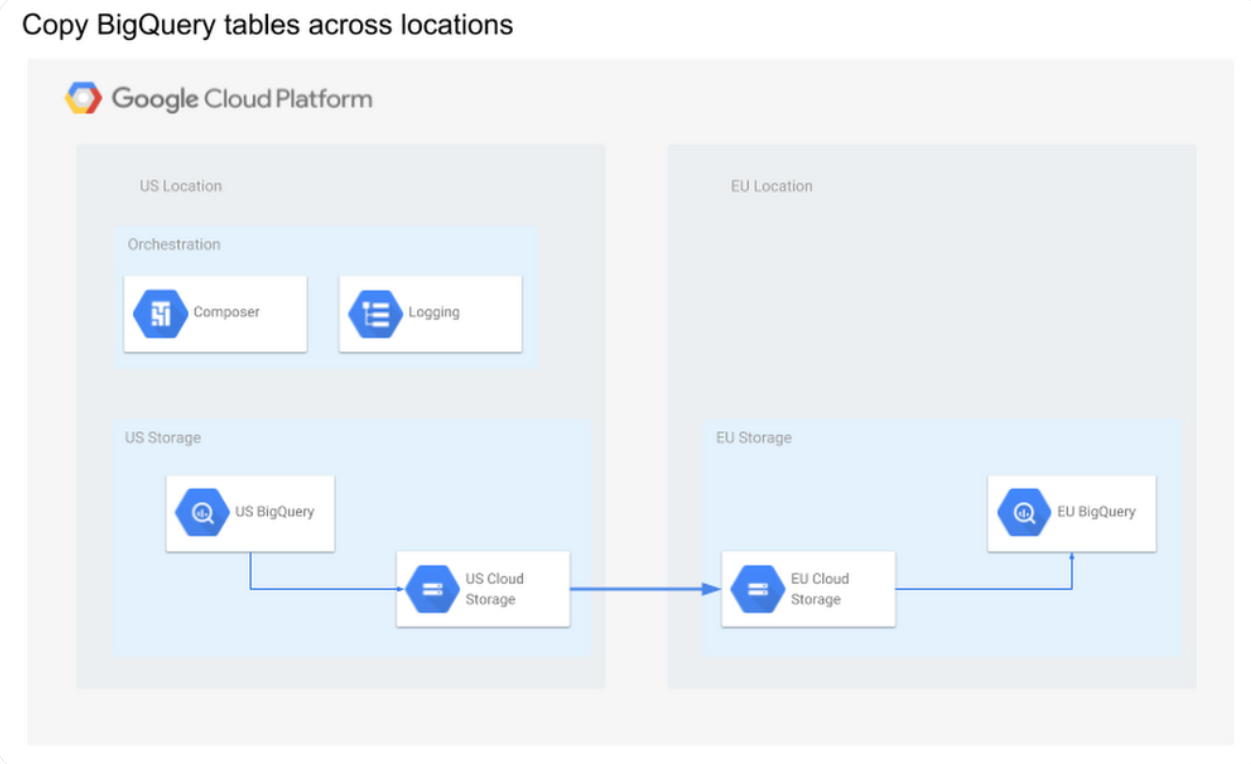

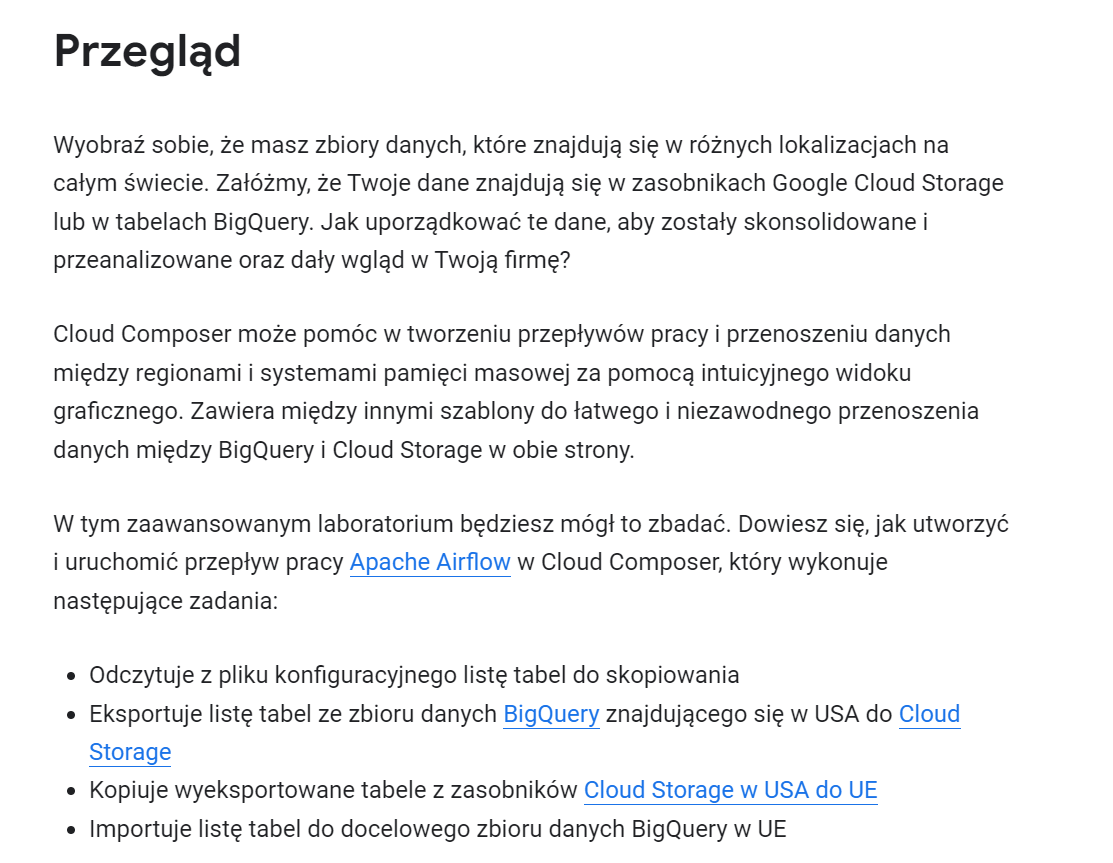

Polecenie gcloud auth list w Google Cloud SDK wyświetla listę kont, które są obecnie uwierzytelnione w narzędziu wiersza poleceń gcloud. Może to być przydatne, aby sprawdzić, które konto jest aktywne i używane do operacji w ramach Google Cloud.

In [ ]:
gcloud auth list

Polecenie gcloud config list project w Google Cloud SDK wyświetla aktualnie skonfigurowany projekt w narzędziu gcloud. Jest to przydatne, gdy chcesz upewnić się, że wszystkie operacje są wykonywane na właściwym projekcie Google Cloud.

In [ ]:
gcloud config list project

Aby zmienić aktualny projekt, użyj polecenia

In [ ]:
gcloud config set project <project-id>

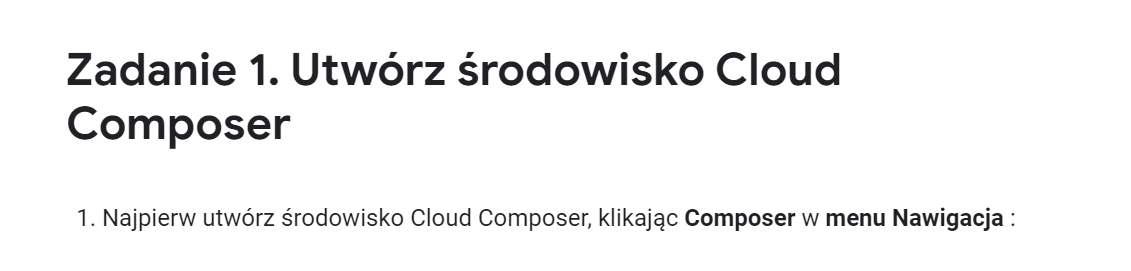

In [ ]:
# composer-advanced-lab

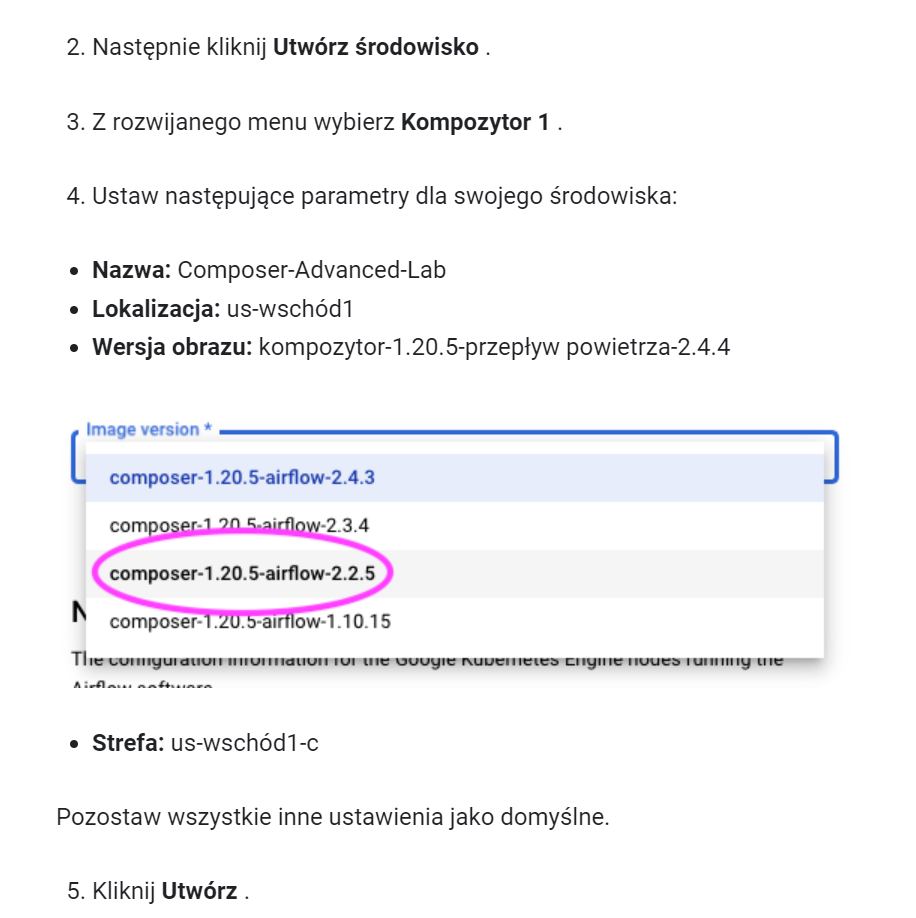

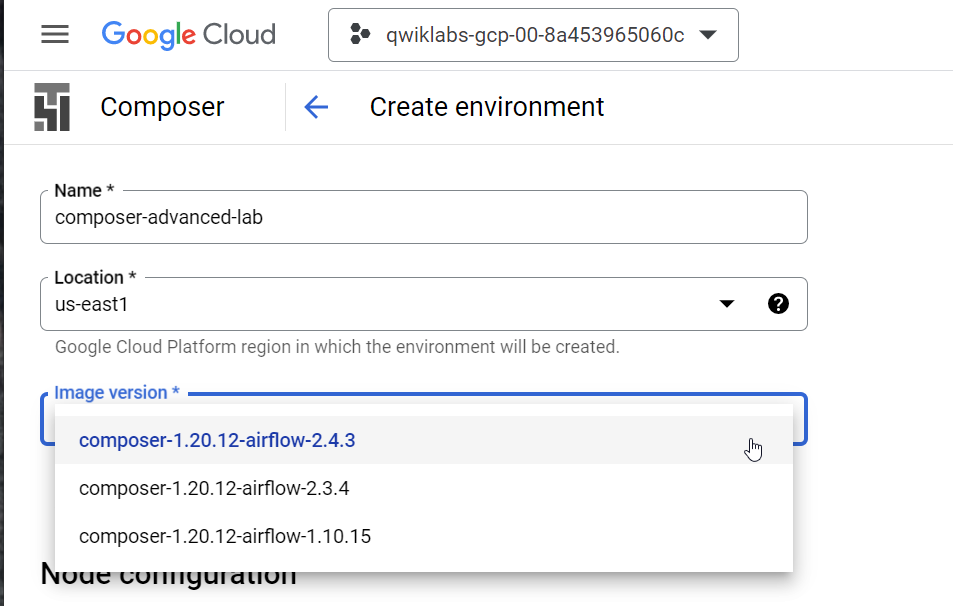

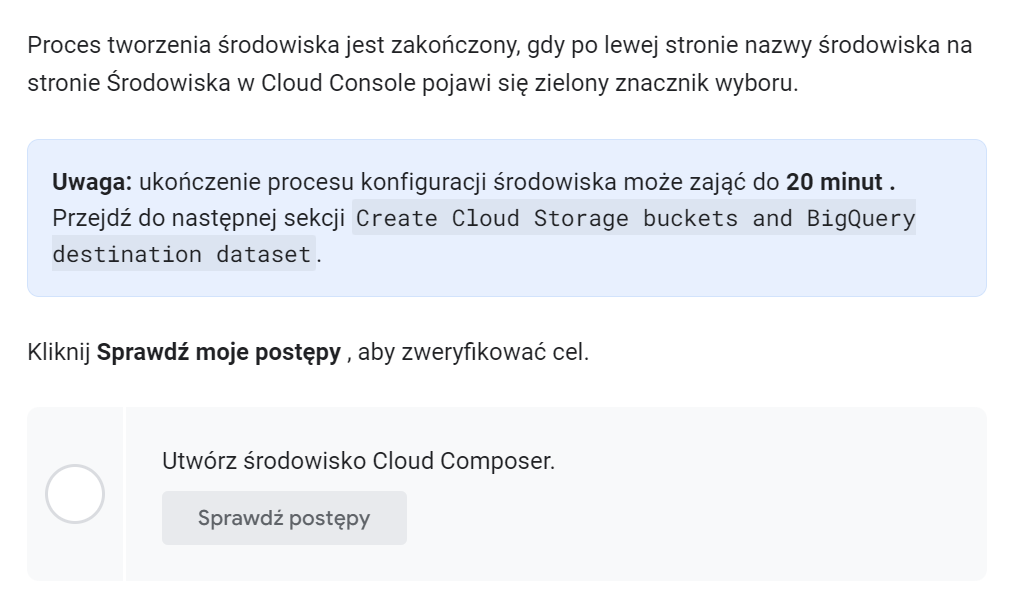

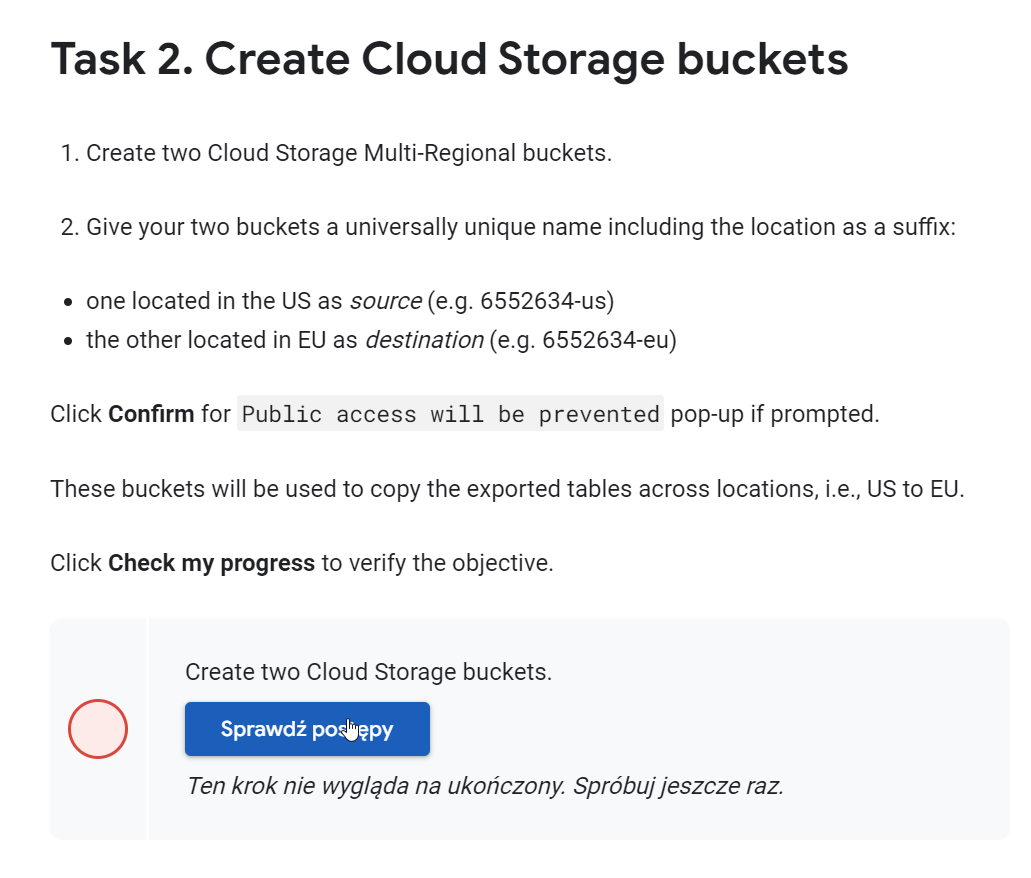

In [ ]:
exam-5848484-us
exam-9789054-eu

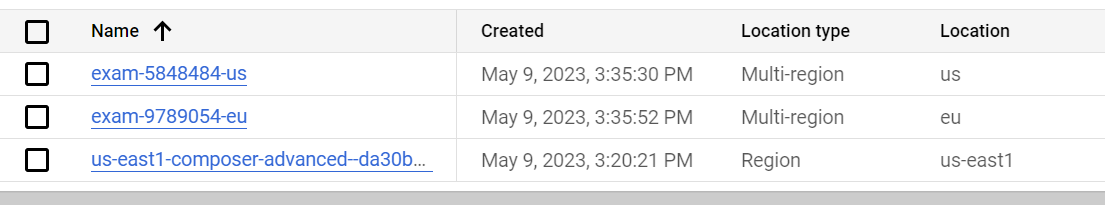

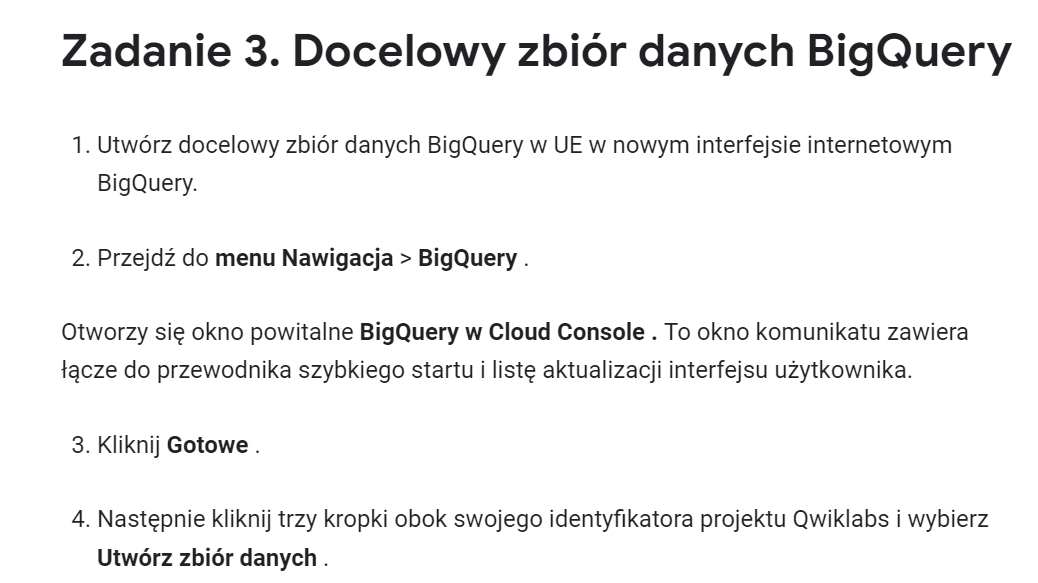

In [ ]:
# nyc_tlc_EU

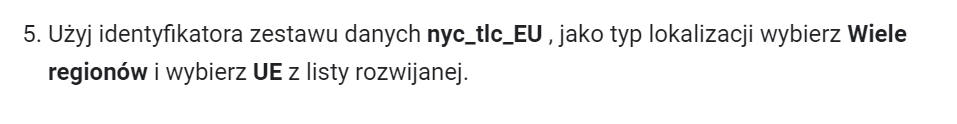

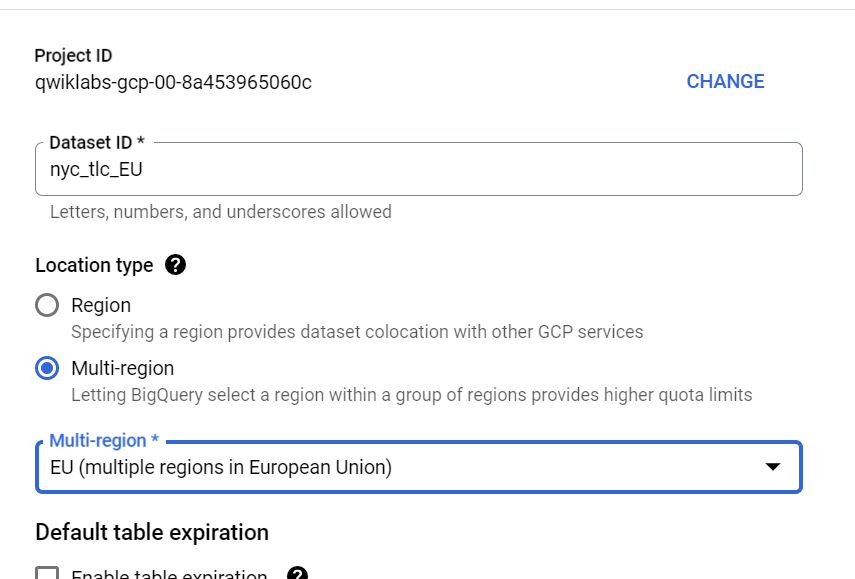

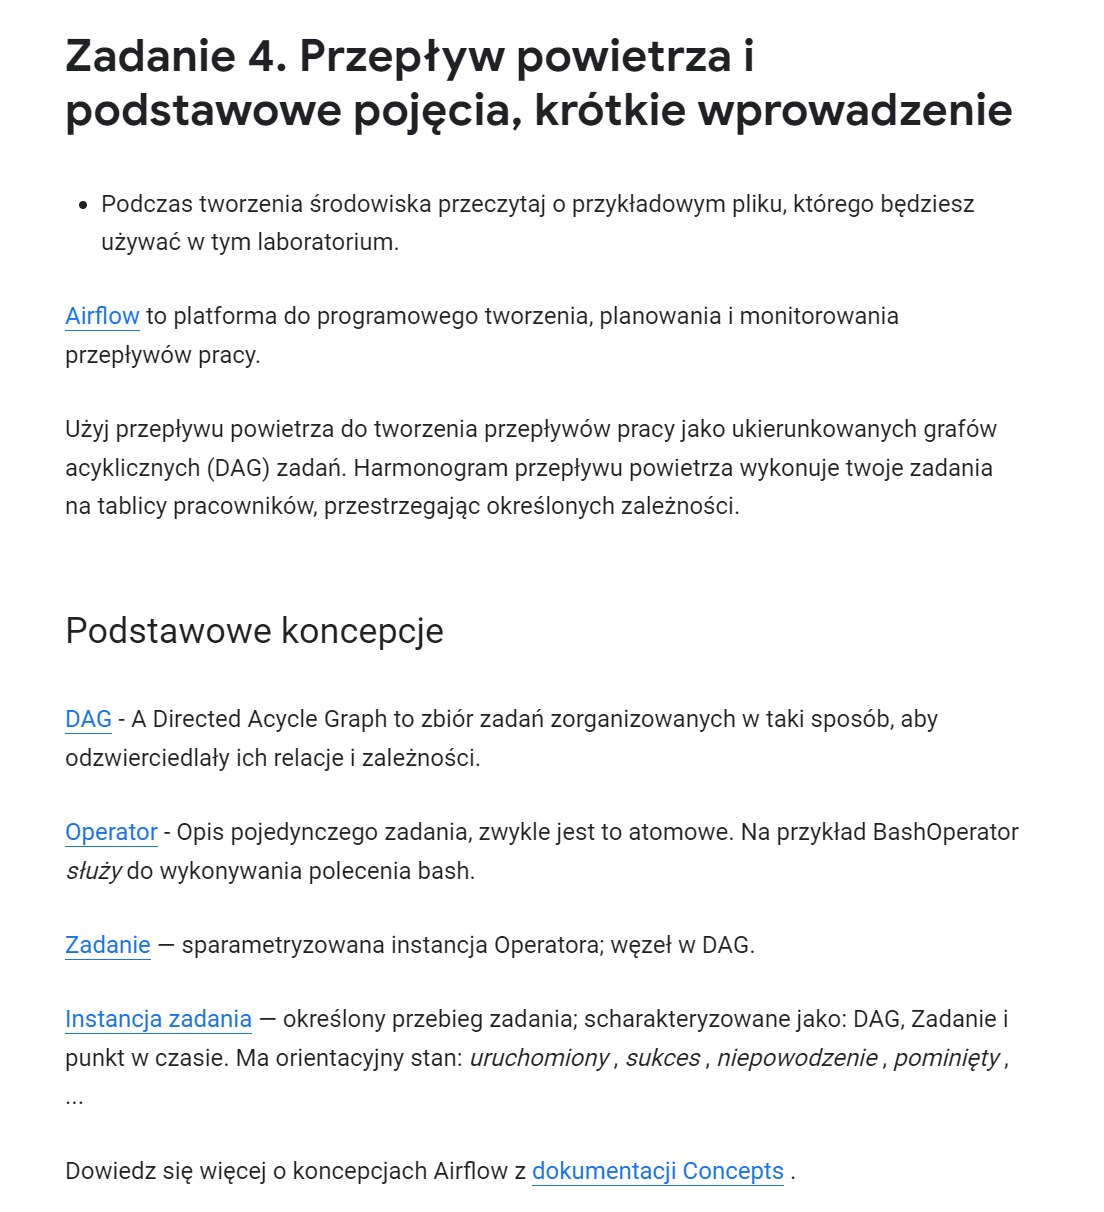

In [ ]:
# https://airflow.apache.org/docs/apache-airflow/1.10.15/concepts.html

# https://airflow.apache.org/docs/apache-airflow/1.10.15/concepts.html#operators

# https://airflow.apache.org/docs/apache-airflow/1.10.15/concepts.html#tasks

# https://airflow.apache.org/docs/apache-airflow/1.10.15/concepts.html#task-instances

# https://airflow.apache.org/docs/apache-airflow/1.10.15/concepts.html

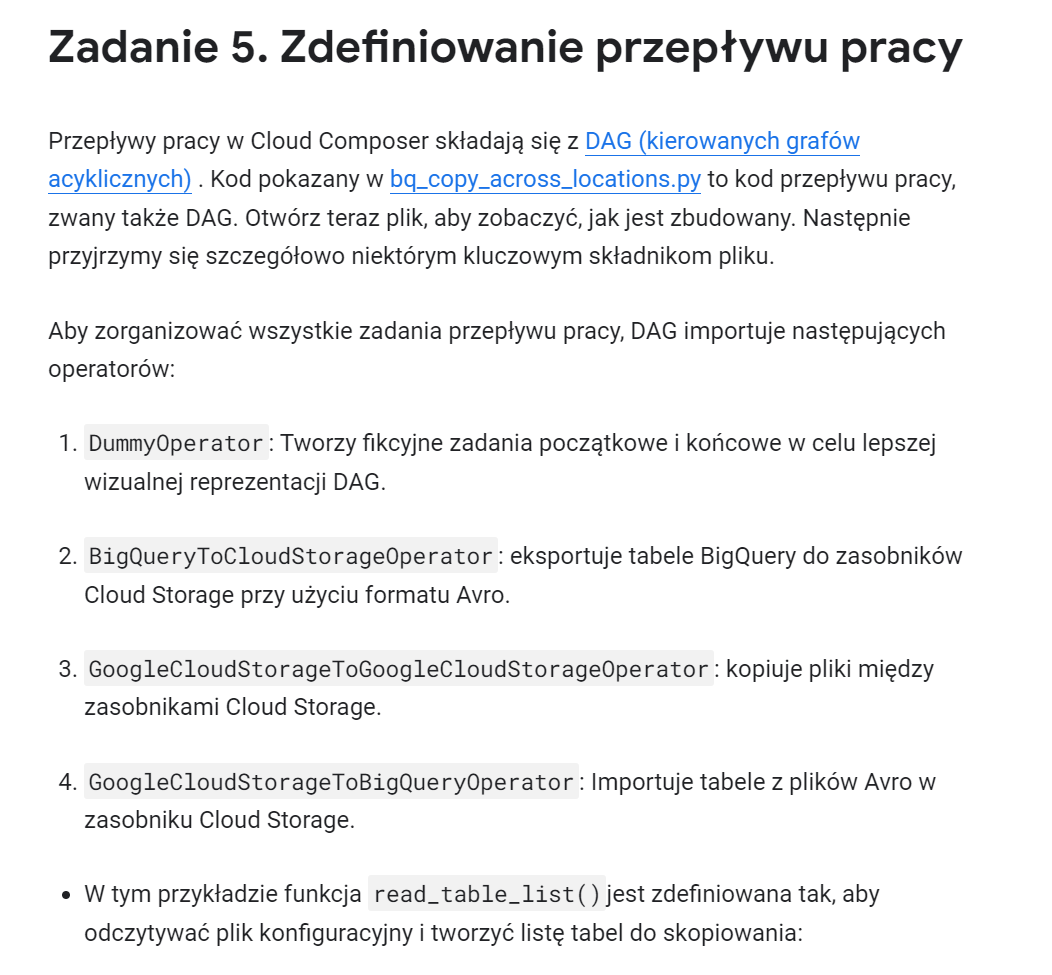

`bq_copy_across_locations.py`

In [ ]:
import csv
import datetime
import io
import logging

from airflow import models
from airflow.contrib.operators import bigquery_to_gcs
from airflow.contrib.operators import gcs_to_bq
from airflow.operators import dummy_operator
# Import operator from plugins
from gcs_plugin.operators import gcs_to_gcs


# --------------------------------------------------------------------------------
# Set default arguments
# --------------------------------------------------------------------------------

default_args = {
    'owner': 'airflow',
    'start_date': datetime.datetime.today(),
    'depends_on_past': False,
    'email': [''],
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': datetime.timedelta(minutes=5),
}

# --------------------------------------------------------------------------------
# Set variables
# --------------------------------------------------------------------------------

# 'table_list_file_path': This variable will contain the location of the master
# file.
table_list_file_path = models.Variable.get('table_list_file_path')

# Source Bucket
source_bucket = models.Variable.get('gcs_source_bucket')

# Destination Bucket
dest_bucket = models.Variable.get('gcs_dest_bucket')

# --------------------------------------------------------------------------------
# Set GCP logging
# --------------------------------------------------------------------------------

logger = logging.getLogger('bq_copy_us_to_eu_01')

# --------------------------------------------------------------------------------
# Functions
# --------------------------------------------------------------------------------


def read_table_list(table_list_file):
    """
    Reads the table list file that will help in creating Airflow tasks in
    the DAG dynamically.
    :param table_list_file: (String) The file location of the table list file,
    e.g. '/home/airflow/framework/table_list.csv'
    :return table_list: (List) List of tuples containing the source and
    target tables.
    """
    table_list = []
    logger.info('Reading table_list_file from : %s' % str(table_list_file))
    try:
        with io.open(table_list_file, 'rt', encoding='utf-8') as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader)  # skip the headers
            for row in csv_reader:
                logger.info(row)
                table_tuple = {
                    'table_source': row[0],
                    'table_dest': row[1]
                }
                table_list.append(table_tuple)
            return table_list
    except IOError as e:
        logger.error('Error opening table_list_file %s: ' % str(
            table_list_file), e)


# --------------------------------------------------------------------------------
# Main DAG
# --------------------------------------------------------------------------------

# Define a DAG (directed acyclic graph) of tasks.
# Any task you create within the context manager is automatically added to the
# DAG object.
with models.DAG('bq_copy_us_to_eu_01',
                default_args=default_args,
                schedule_interval=None) as dag:
    start = dummy_operator.DummyOperator(
        task_id='start',
        trigger_rule='all_success'
    )

    end = dummy_operator.DummyOperator(
        task_id='end',

        trigger_rule='all_success'
    )

    # Get the table list from master file
    all_records = read_table_list(table_list_file_path)

    # Loop over each record in the 'all_records' python list to build up
    # Airflow tasks
    for record in all_records:
        logger.info('Generating tasks to transfer table: {}'.format(record))

        table_source = record['table_source']
        table_dest = record['table_dest']

        BQ_to_GCS = bigquery_to_gcs.BigQueryToCloudStorageOperator(
            # Replace ":" with valid character for Airflow task
            task_id='{}_BQ_to_GCS'.format(table_source.replace(":", "_")),
            source_project_dataset_table=table_source,
            destination_cloud_storage_uris=['{}-*.avro'.format(
                'gs://' + source_bucket + '/' + table_source)],
            export_format='AVRO'
        )

        GCS_to_GCS = gcs_to_gcs.GoogleCloudStorageToGoogleCloudStorageOperator(
            # Replace ":" with valid character for Airflow task
            task_id='{}_GCS_to_GCS'.format(table_source.replace(":", "_")),
            source_bucket=source_bucket,
            source_object='{}-*.avro'.format(table_source),
            destination_bucket=dest_bucket,
            # destination_object='{}-*.avro'.format(table_dest)
        )

        GCS_to_BQ = gcs_to_bq.GoogleCloudStorageToBigQueryOperator(
            # Replace ":" with valid character for Airflow task
            task_id='{}_GCS_to_BQ'.format(table_dest.replace(":", "_")),
            bucket=dest_bucket,
            source_objects=['{}-*.avro'.format(table_source)],
            destination_project_dataset_table=table_dest,
            source_format='AVRO',
            write_disposition='WRITE_TRUNCATE'
        )

        start >> BQ_to_GCS >> GCS_to_GCS >> GCS_to_BQ >> end

Komentarze

In [ ]:
import csv
import datetime
import io # Zapewnia narzędzia do obsługi strumieni wejścia/wyjścia w Pythonie.
import logging # Używana do rejestrowania zdarzeń, co jest szczególnie przydatne w przepływach pracy dla debugowania.

from airflow import models # Główna biblioteka Apache Airflow zawierająca klasy DAG i inne podstawowe komponenty do zarządzania przepływami pracy.
from airflow.contrib.operators import bigquery_to_gcs # Operator, który eksportuje dane z BigQuery do Google Cloud Storage (GCS).
from airflow.contrib.operators import gcs_to_bq # Operator, który ładuje dane z GCS do BigQuery.
from airflow.operators import dummy_operator

'''Operator niestandardowy, który kopiuje pliki między różnymi bucketami lub ścieżkami w Google Cloud Storage (GCS).
Ten operator pochodzi z własnej wtyczki (gcs_plugin), co sugeruje, że została ona stworzona lub zmodyfikowana
dla specyficznych potrzeb projektu.'''
from gcs_plugin.operators import gcs_to_gcs


# --------------------------------------------------------------------------------
# Set default arguments
# --------------------------------------------------------------------------------

default_args = {
    'owner': 'airflow',
    # Właściciel przepływu pracy. Informacja pomocna w monitorowaniu i organizacji DAG-ów.
    'start_date': datetime.datetime.today(),
    # Data rozpoczęcia wykonywania DAG-a. `datetime.datetime.today()` ustawia bieżącą datę i czas.
    # W praktyce, w przypadku Airflow zaleca się używanie `datetime.datetime(rok, miesiąc, dzień)`
    # zamiast `today()`, aby uniknąć problemów z harmonogramem.
    'depends_on_past': False,
    # Określa, czy zadanie w DAG-u zależy od sukcesu poprzedniego uruchomienia.
    # False oznacza, że każde zadanie działa niezależnie.
    'email': [''],
    # Lista adresów e-mail, na które zostaną wysłane powiadomienia (opcjonalne).
    'email_on_failure': False,
    # Czy wysyłać e-mail w przypadku niepowodzenia zadania. False oznacza brak powiadomień.
    'email_on_retry': False,
    # Czy wysyłać e-mail w przypadku ponowienia zadania. False oznacza brak powiadomień.
    'retries': 1,
    # Liczba prób wykonania zadania w przypadku jego niepowodzenia. W tym przypadku jedna próba.
    'retry_delay': datetime.timedelta(minutes=5),
    # Opóźnienie przed ponownym uruchomieniem zadania w przypadku jego niepowodzenia.
    # Tutaj wynosi 5 minut.
}

# --------------------------------------------------------------------------------
# Set variables
# --------------------------------------------------------------------------------

# Możesz użyć tej zmiennej do wskazania lokalizacji pliku głównego (np. CSV), który zawiera listę tabel do przetwarzania.
table_list_file_path = models.Variable.get('table_list_file_path')

# Określenie lokalizacji w GCS, skąd dane będą pobierane.
source_bucket = models.Variable.get('gcs_source_bucket')

# Lokalizacja w GCS, gdzie dane będą zapisywane po przetworzeniu.
dest_bucket = models.Variable.get('gcs_dest_bucket')

# --------------------------------------------------------------------------------
# Set GCP logging
# --------------------------------------------------------------------------------

'''Ten fragment kodu włącza logowanie w GCP dla konkretnego zadania przetwarzania danych w Airflow.
W przypadku uruchamiania w Airflow, logi są dostępne w interfejsie użytkownika pod zakładką “Logs” dla konkretnego zadania.
Jeśli używasz GCP, logi mogą być również przesyłane do Google Cloud Logging.'''

logger = logging.getLogger('bq_copy_us_to_eu_01')


#  Funkcja read_table_list() jest zdefiniowana tak, aby odczytać plik konfiguracyjny i zbudować listę tabel do skopiowania
def read_table_list(table_list_file):
    """
    Odczytuje plik listy tabel, który pomoże w dynamicznym tworzeniu zadań Airflow w DAG.
    :param table_list_file: (String) Lokalizacja pliku listy tabel,
    np. '/home/airflow/framework/table_list.csv'
    :return table_list: (Lista) Lista krotek zawierających tabele źródłowe i
    docelowe.
    """
    table_list = []  # Tworzymy pustą listę, która będzie przechowywać informacje o tabelach
    logger.info('Reading table_list_file from : %s' % str(table_list_file))  # Logowanie informacji o rozpoczęciu odczytu pliku
    try:
        # Otwieramy plik CSV, używając kodowania UTF-8
        with io.open(table_list_file, 'rt', encoding='utf-8') as csv_file:
            # Tworzymy obiekt do odczytu CSV
            csv_reader = csv.reader(csv_file)
            next(csv_reader)  # Pomijamy pierwszy wiersz, który zawiera nagłówki
            for row in csv_reader:  # Iterujemy po wszystkich wierszach pliku
                logger.info(row)  # Logujemy każdy wiersz, aby śledzić odczytywane dane
                # Tworzymy słownik z nazwami źródłowej i docelowej tabeli
                table_tuple = {
                    'table_source': row[0],  # Pierwsza kolumna to tabela źródłowa
                    'table_dest': row[1]  # Druga kolumna to tabela docelowa
                }
                table_list.append(table_tuple)  # Dodajemy słownik do listy
            return table_list  # Zwracamy pełną listę tabel
    except IOError as e:  # Jeśli wystąpi błąd przy otwieraniu pliku
        logger.error('Error opening table_list_file %s: ' % str(table_list_file), e)  # Logujemy błąd otwarcia pliku




with models.DAG('bq_copy_us_to_eu_01',  # Tworzymy nowy DAG w Airflow o nazwie 'bq_copy_us_to_eu_01'
                default_args=default_args,  # Ustawiamy domyślne argumenty dla DAG (np. czas rozpoczęcia, powiadomienia)
                schedule_interval=None) as dag:  # Harmonogram wykonywania DAG - None oznacza, że zadanie nie będzie wykonywane cyklicznie


    start = dummy_operator.DummyOperator(  # Tworzymy pierwszy operator w DAG - zadanie startowe
        task_id='start',  # Nazwa zadania w DAG
        trigger_rule='all_success'  # Zadanie 'start' zostanie wykonane tylko jeśli wszystkie poprzednie zadania zakończą się sukcesem
    )

    end = dummy_operator.DummyOperator(  # Tworzymy drugi operator w DAG - zadanie końcowe
        task_id='end',  # Nazwa zadania w DAG
        trigger_rule='all_success'  # Zadanie 'end' będzie wykonane tylko wtedy, gdy wszystkie poprzednie zadania zakończą się sukcesem
    )

    # Get the table list from master file
    all_records = read_table_list(table_list_file_path)  # Odczytujemy listę tabel z pliku master

    # Loop over each record in the 'all_records' python list to build up
    # Airflow tasks
    for record in all_records:  # Iterujemy przez każdy rekord w odczytanej liście tabel
        logger.info('Generating tasks to transfer table: {}'.format(record))  # Logujemy informację o generowaniu zadań dla danej tabeli

        table_source = record['table_source']  # Pobieramy nazwę tabeli źródłowej z rekordu
        table_dest = record['table_dest']  # Pobieramy nazwę tabeli docelowej z rekordu

        # Tworzymy operator BigQueryToCloudStorageOperator, który przenosi dane z BigQuery do Google Cloud Storage
        BQ_to_GCS = bigquery_to_gcs.BigQueryToCloudStorageOperator(
            task_id='{}_BQ_to_GCS'.format(table_source.replace(":", "_")),  # Tworzymy unikalną nazwę zadania, zastępując ":" znakiem "_"
            source_project_dataset_table=table_source,  # Określamy źródłową tabelę w BigQuery
            destination_cloud_storage_uris=['{}-*.avro'.format(
                'gs://' + source_bucket + '/' + table_source)],  # Określamy docelowy folder w Google Cloud Storage
            export_format='AVRO'  # Określamy format eksportu danych (AVRO)
        )

        # Tworzymy operator GoogleCloudStorageToGoogleCloudStorageOperator, który kopiuje dane między bucketami w GCS
        GCS_to_GCS = gcs_to_gcs.GoogleCloudStorageToGoogleCloudStorageOperator(
            task_id='{}_GCS_to_GCS'.format(table_source.replace(":", "_")),  # Tworzymy unikalną nazwę zadania
            source_bucket=source_bucket,  # Źródłowy bucket w GCS
            source_object='{}-*.avro'.format(table_source),  # Określamy pliki źródłowe w GCS
            destination_bucket=dest_bucket,  # Docelowy bucket w GCS
        )

        # Tworzymy operator GoogleCloudStorageToBigQueryOperator, który przenosi dane z GCS do BigQuery
        GCS_to_BQ = gcs_to_bq.GoogleCloudStorageToBigQueryOperator(
            task_id='{}_GCS_to_BQ'.format(table_dest.replace(":", "_")),  # Tworzymy unikalną nazwę zadania
            bucket=dest_bucket,  # Określamy docelowy bucket w GCS
            source_objects=['{}-*.avro'.format(table_source)],  # Źródłowy plik w GCS
            destination_project_dataset_table=table_dest,  # Określamy docelową tabelę w BigQuery
            source_format='AVRO',  # Określamy format danych źródłowych (AVRO)
            write_disposition='WRITE_TRUNCATE'  # Określamy, że istniejące dane w BigQuery zostaną zastąpione
        )

        # Określamy zależności pomiędzy zadaniami
        start >> BQ_to_GCS >> GCS_to_GCS >> GCS_to_BQ >> end  # Wykonanie zadań w kolejności start -> BQ_to_GCS -> GCS_to_GCS -> GCS_to_BQ -> end

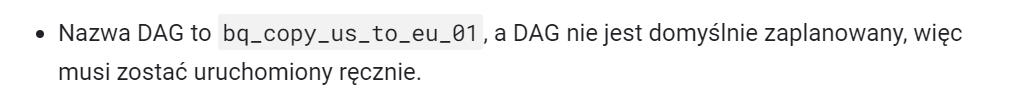

In [ ]:
default_args = {
    'owner': 'airflow',
    'start_date': datetime.today(),
    'depends_on_past': False,
    'email': [''],
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}
# DAG object.
with models.DAG('bq_copy_us_to_eu_01',
                default_args=default_args,
                schedule_interval=None) as dag:

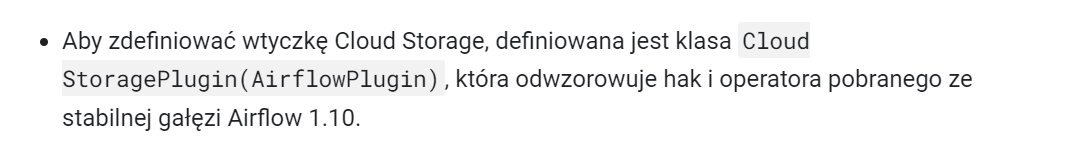

In [ ]:
# Import operator from plugins
from gcs_plugin.operators import gcs_to_gcs

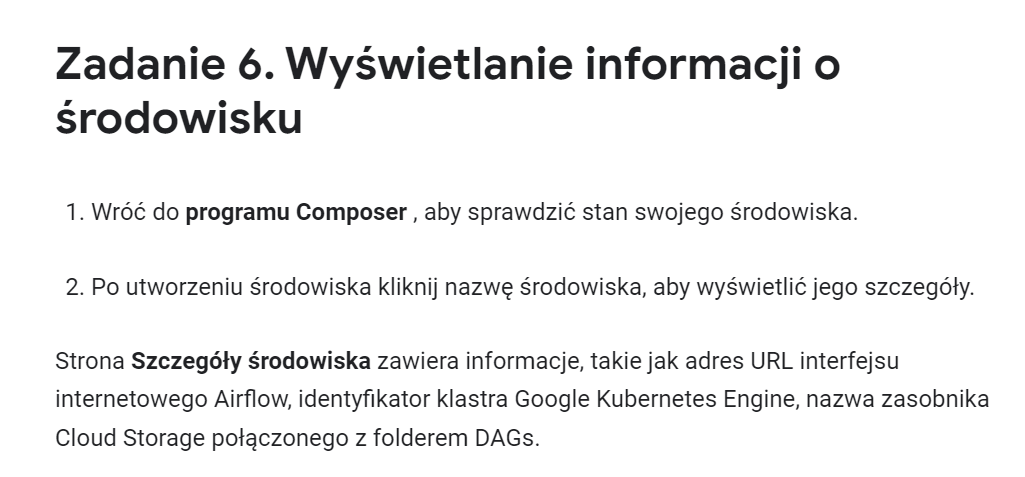

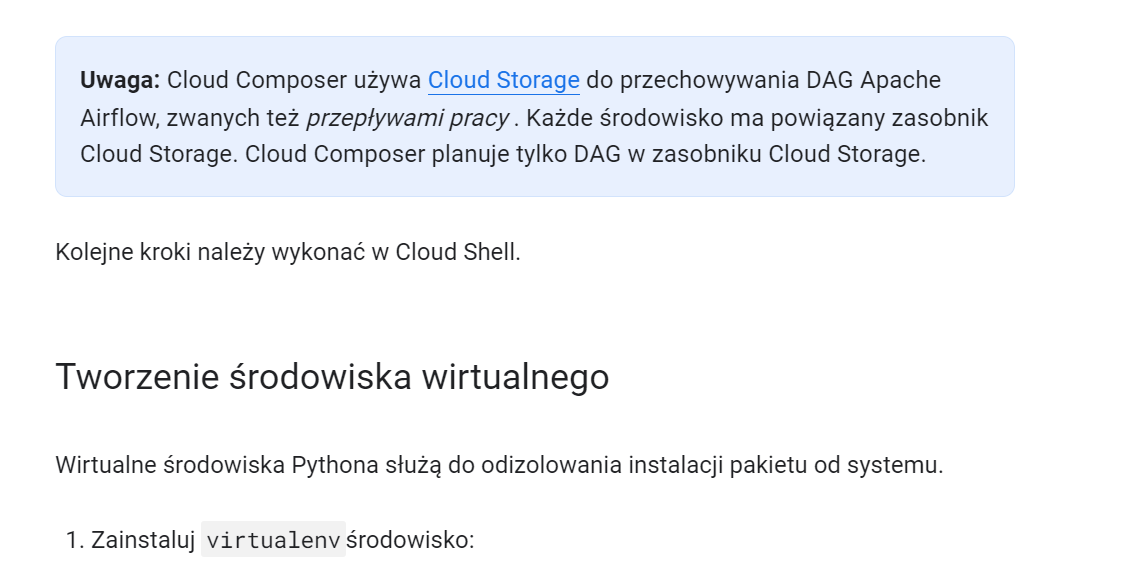

In [ ]:
sudo apt-get install -y virtualenv

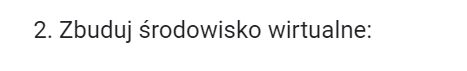

In [ ]:
python3 -m venv venv

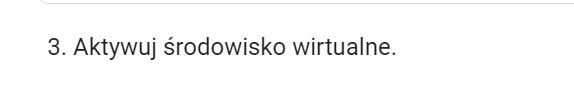

In [ ]:
source venv/bin/activate

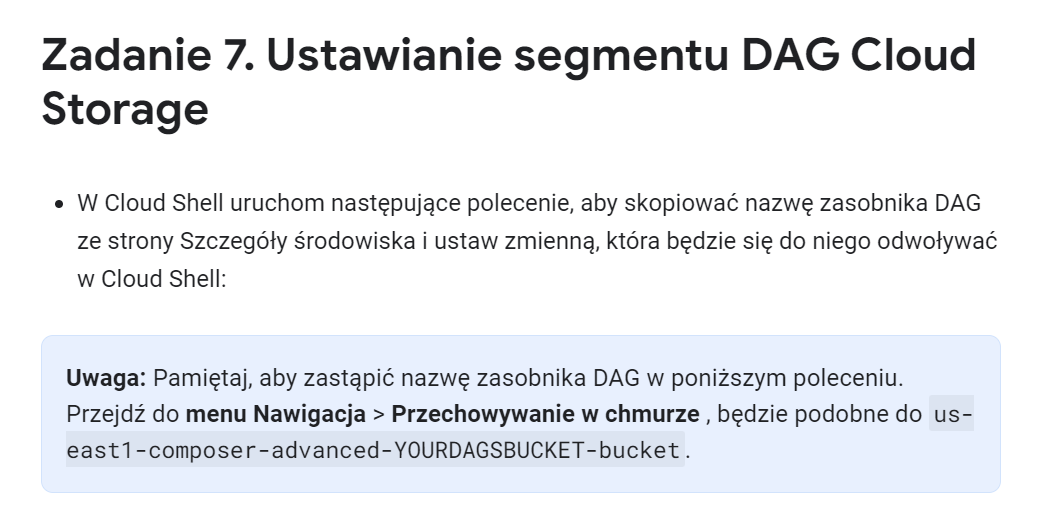

In [ ]:
# DAGS_BUCKET=<your DAGs bucket name>

In [ ]:
DAGS_BUCKET=us-east1-composer-advanced--da30b4f0-bucket

In [ ]:
# gs://us-east1-composer-advanced--da30b4f0-bucket/dags

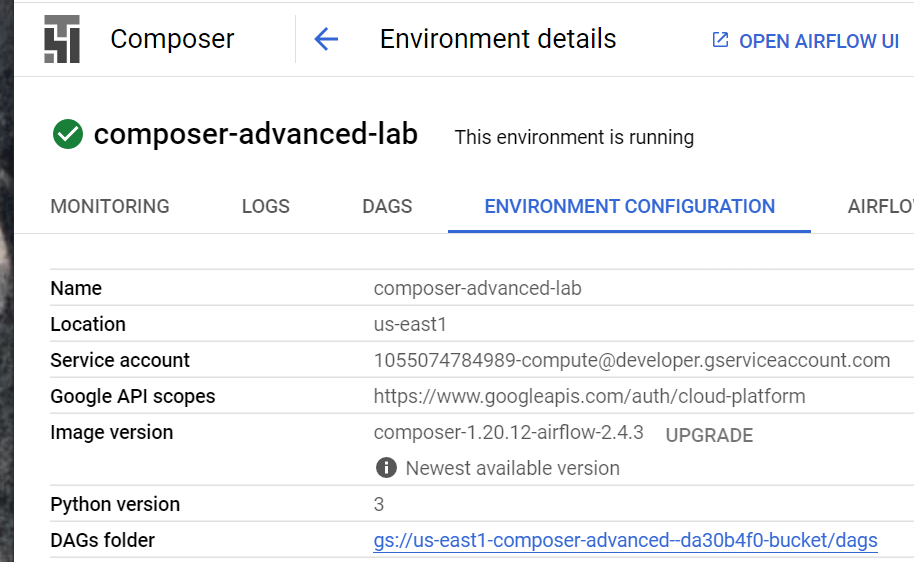

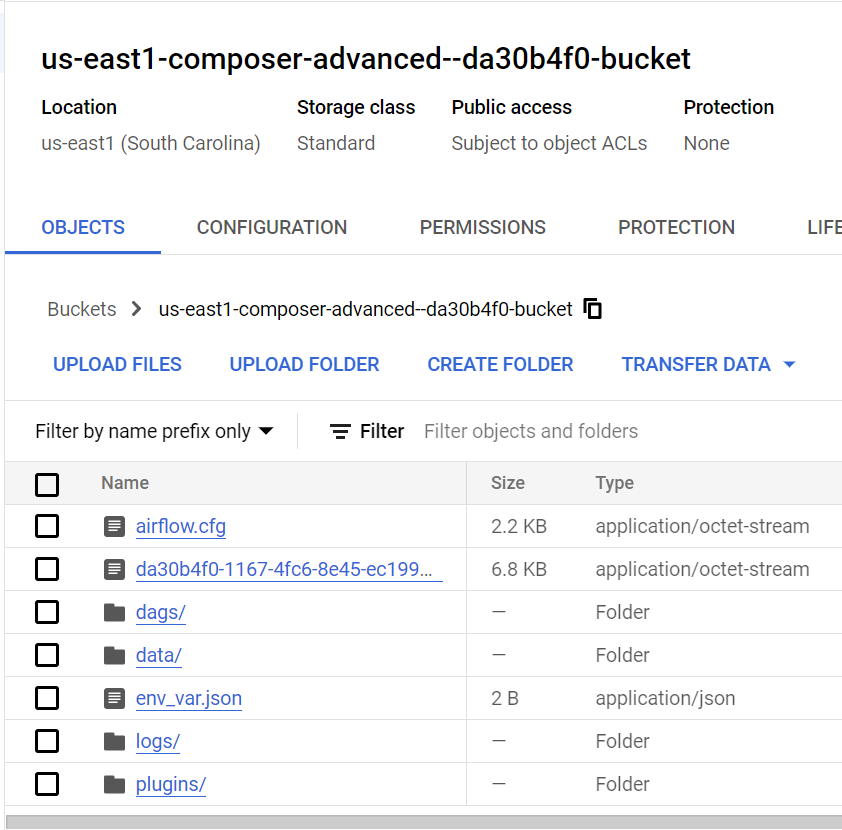

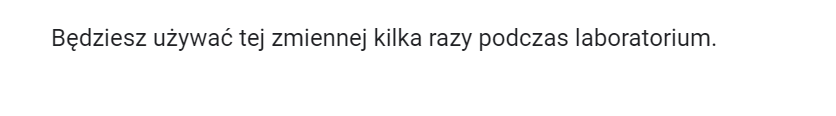

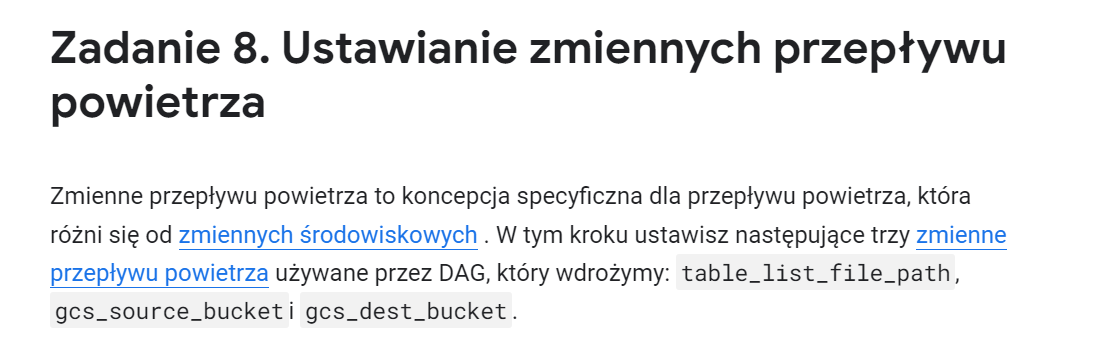

In [ ]:
# --------------------------------------------------------------------------------
# Set variables
# --------------------------------------------------------------------------------

# 'table_list_file_path': This variable will contain the location of the master
# file.
table_list_file_path = models.Variable.get('table_list_file_path')

# Source Bucket
source_bucket = models.Variable.get('gcs_source_bucket')

# Destination Bucket
dest_bucket = models.Variable.get('gcs_dest_bucket')

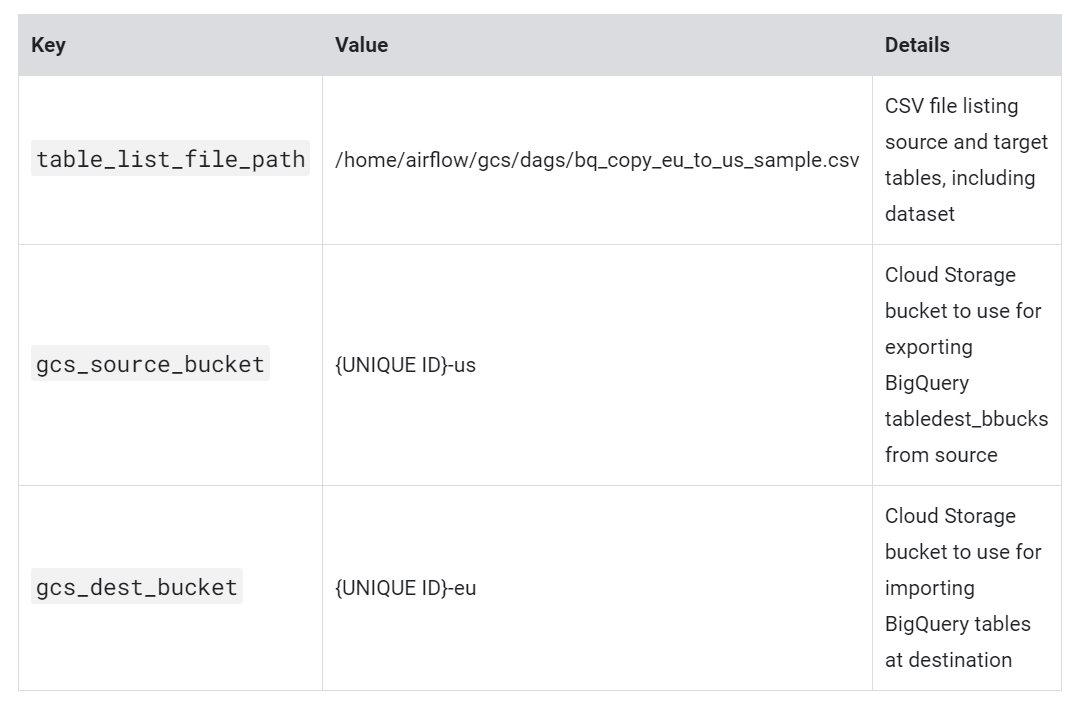

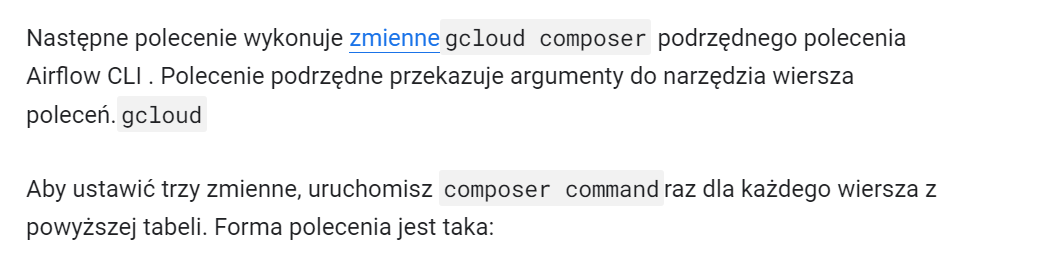

In [ ]:
# https://airflow.apache.org/docs/apache-airflow/stable/cli-and-env-variables-ref.html#variables

In [ ]:
# gcloud composer environments run ENVIRONMENT_NAME \
# --location LOCATION variables -- \
# set KEY VALUE

In [ ]:
# exam-5848484-us
# exam-9789054-eu

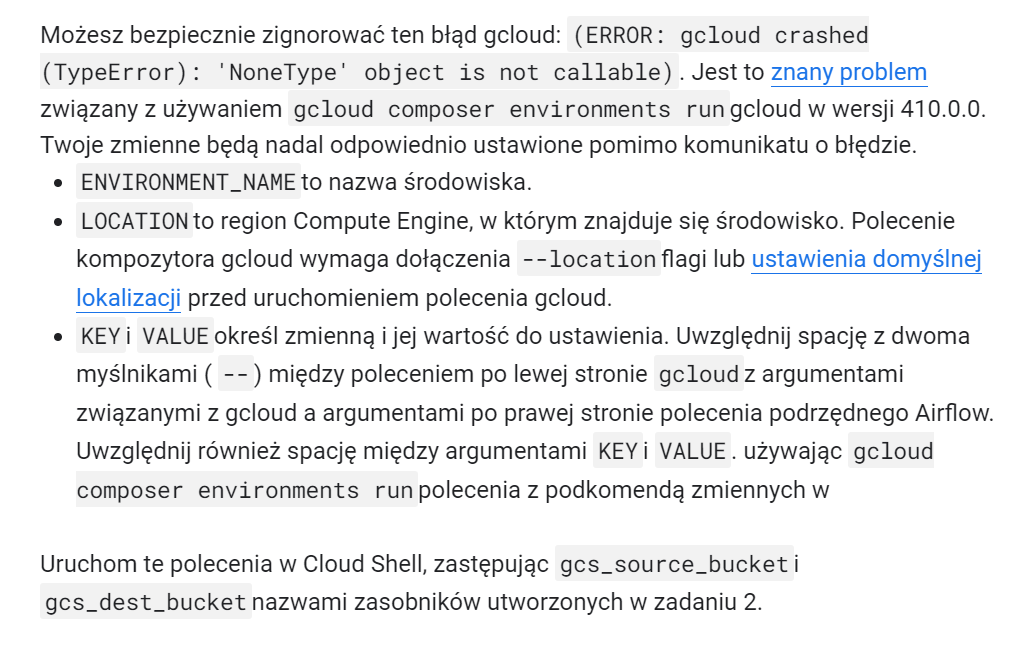

In [ ]:
gcloud composer environments run composer-advanced-lab \
--location us-east1 variables -- \
set table_list_file_path /home/airflow/gcs/dags/bq_copy_eu_to_us_sample.csv

gcloud composer environments run composer-advanced-lab \
--location us-east1 variables -- \
set gcs_source_bucket exam-5848484-us

gcloud composer environments run composer-advanced-lab \
--location us-east1 variables -- \
set gcs_dest_bucket exam-9789054-eu

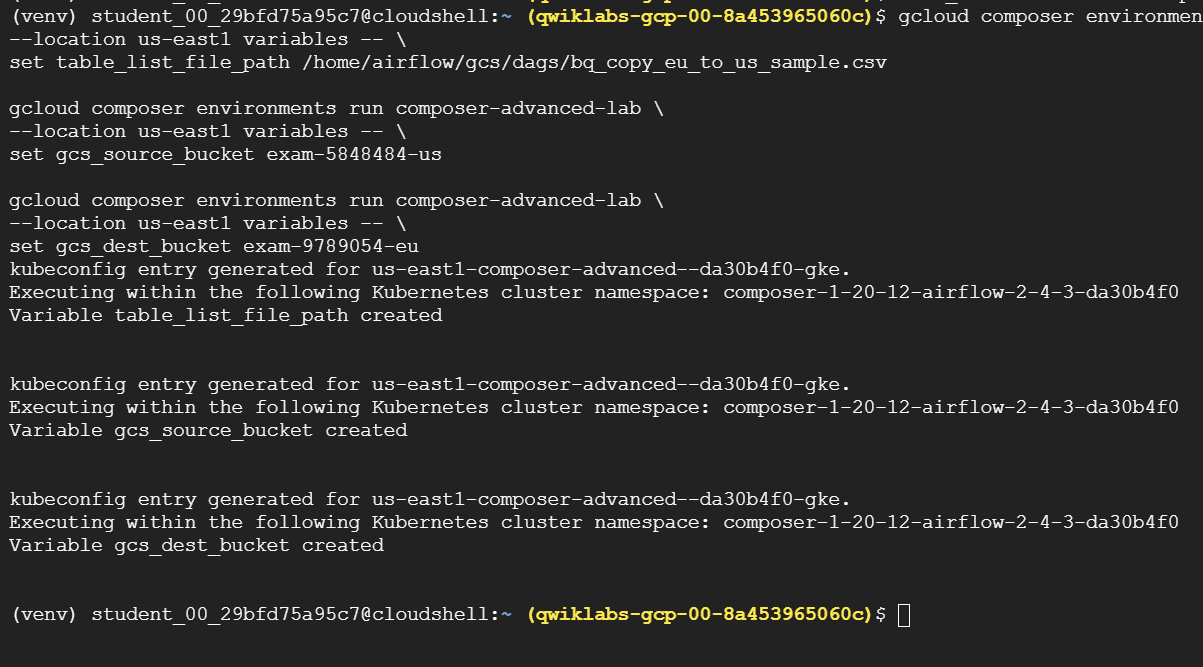

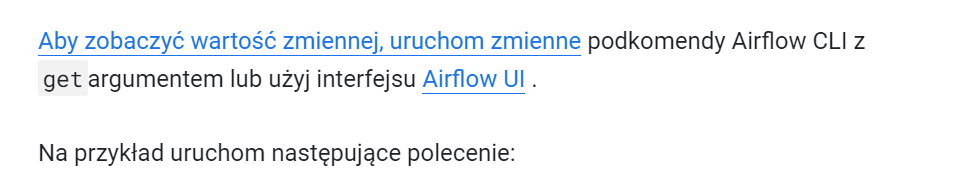

In [ ]:
# https://airflow.apache.org/docs/apache-airflow/stable/cli-and-env-variables-ref.html#variables

# https://cloud.google.com/composer/docs/run-apache-airflow-dag#variables-ui

In [ ]:
gcloud composer environments run composer-advanced-lab \
    --location us-east1 variables -- \
    get table_list_file_path

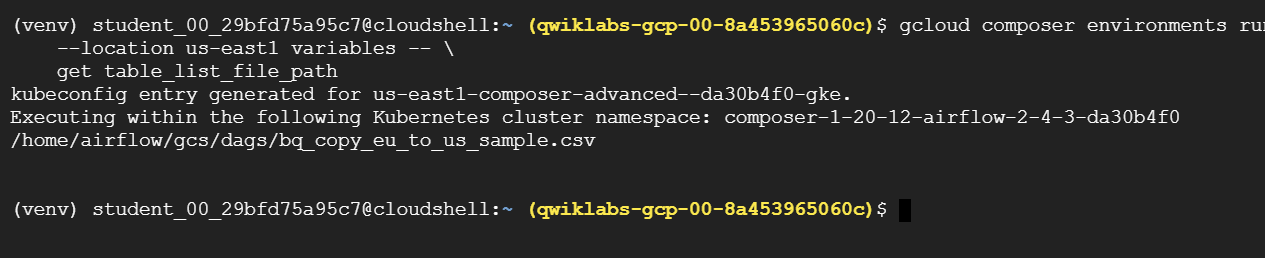

In [ ]:
gcloud composer environments run composer-advanced-lab \
    --location us-east1 variables -- \
    get gcs_source_bucket

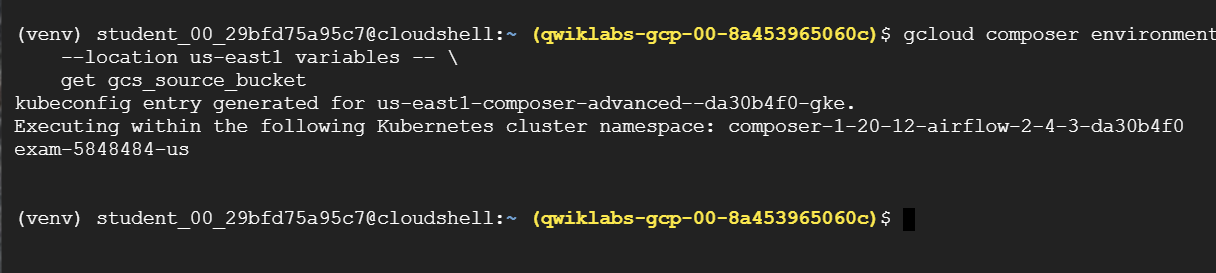

In [ ]:
gcloud composer environments run composer-advanced-lab \
    --location us-east1 variables -- \
    get gcs_dest_bucket

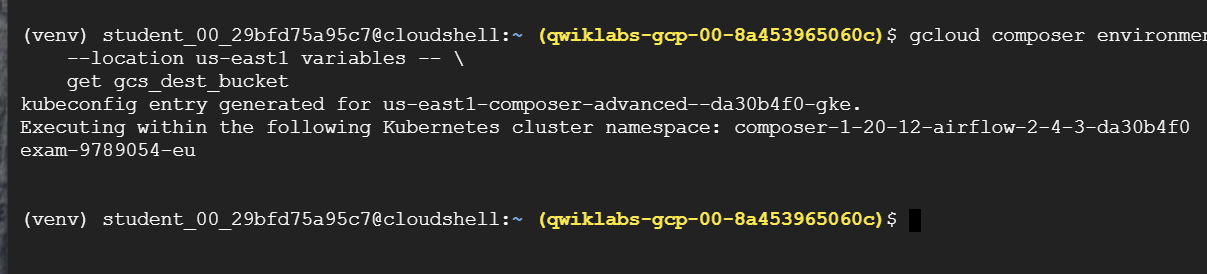

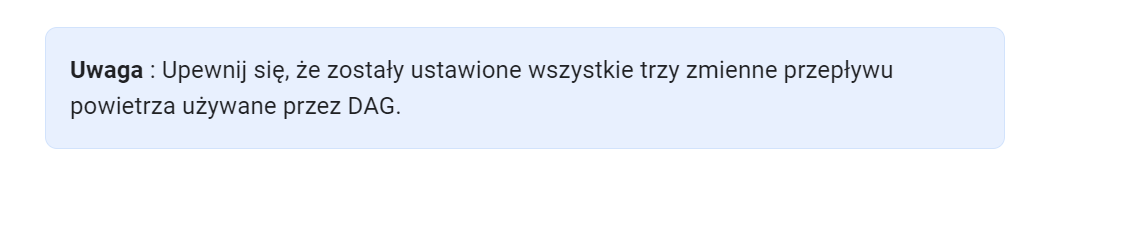

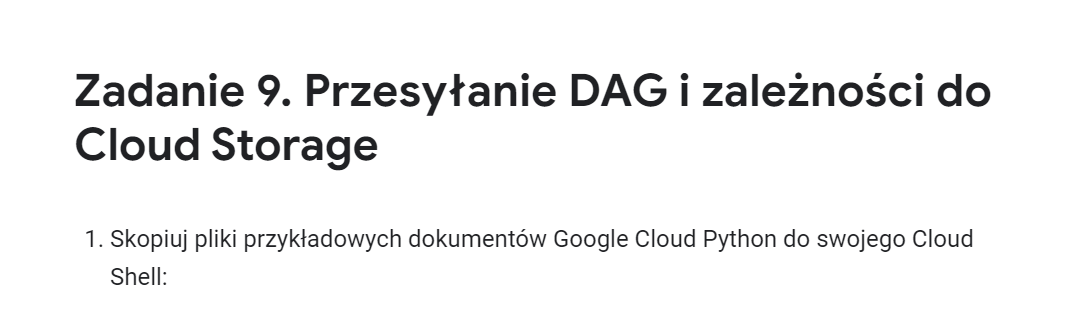

In [ ]:
cd ~
gsutil -m cp -r gs://spls/gsp283/python-docs-samples .

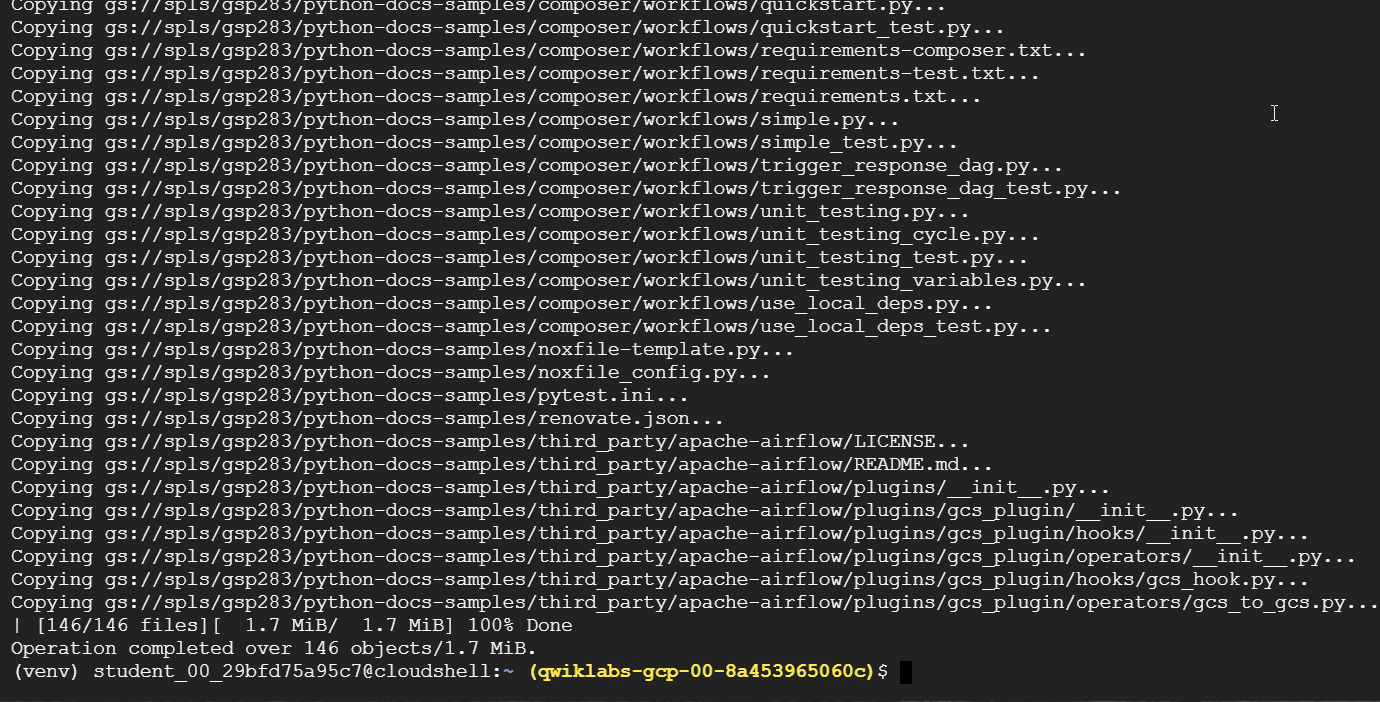

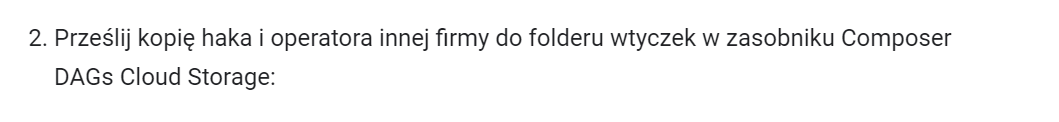

In [ ]:
gsutil cp -r python-docs-samples/third_party/apache-airflow/plugins/* gs://$DAGS_BUCKET/plugins

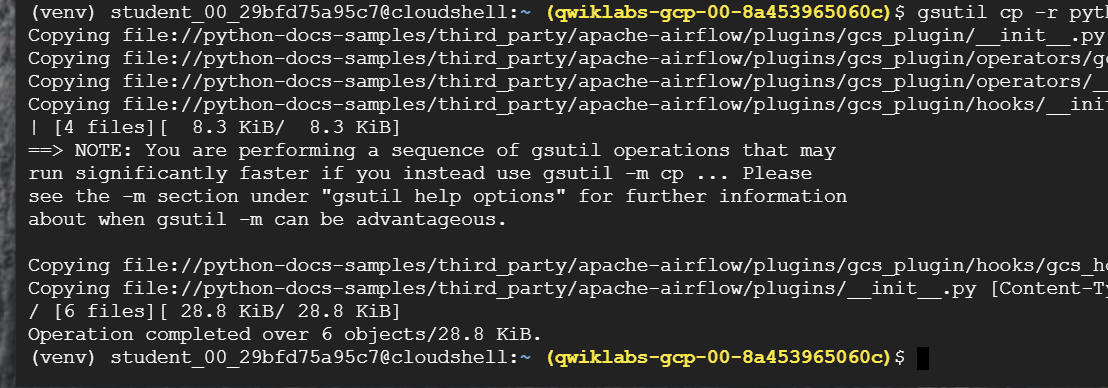

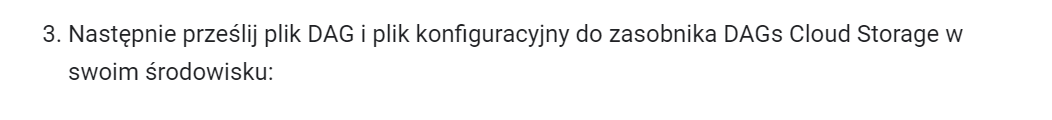

In [ ]:
gsutil cp python-docs-samples/composer/workflows/bq_copy_across_locations.py gs://$DAGS_BUCKET/dags
gsutil cp python-docs-samples/composer/workflows/bq_copy_eu_to_us_sample.csv gs://$DAGS_BUCKET/dags

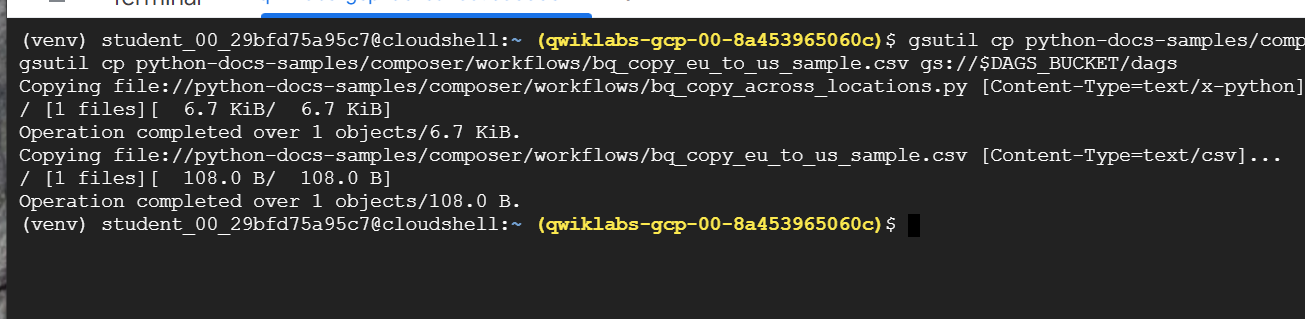

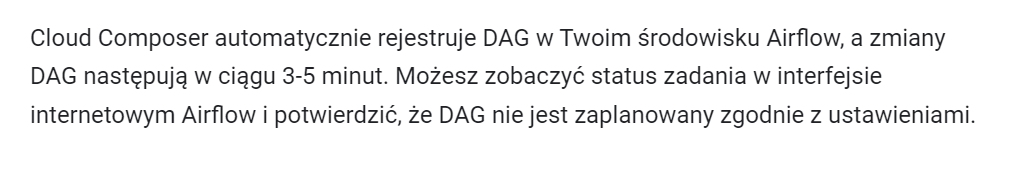

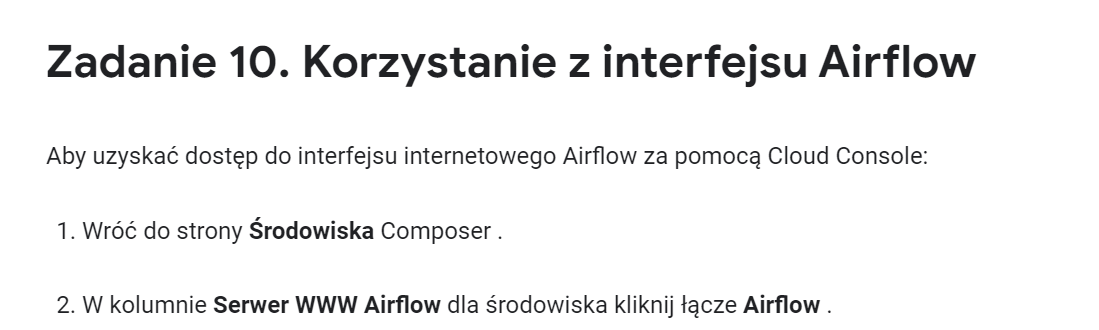

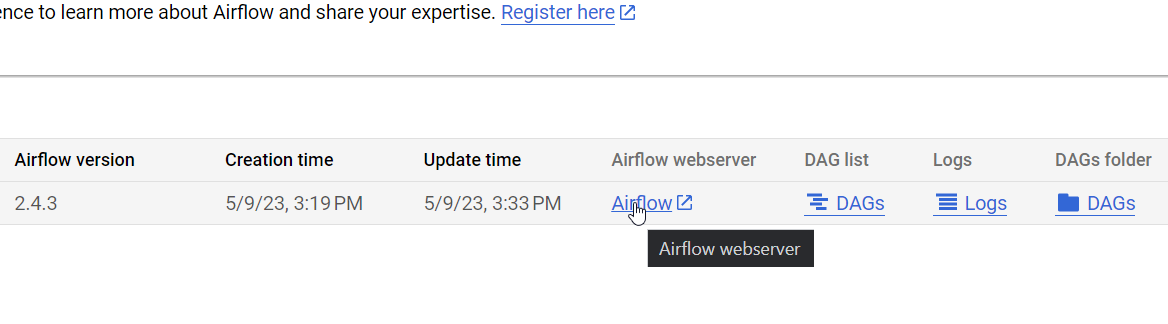

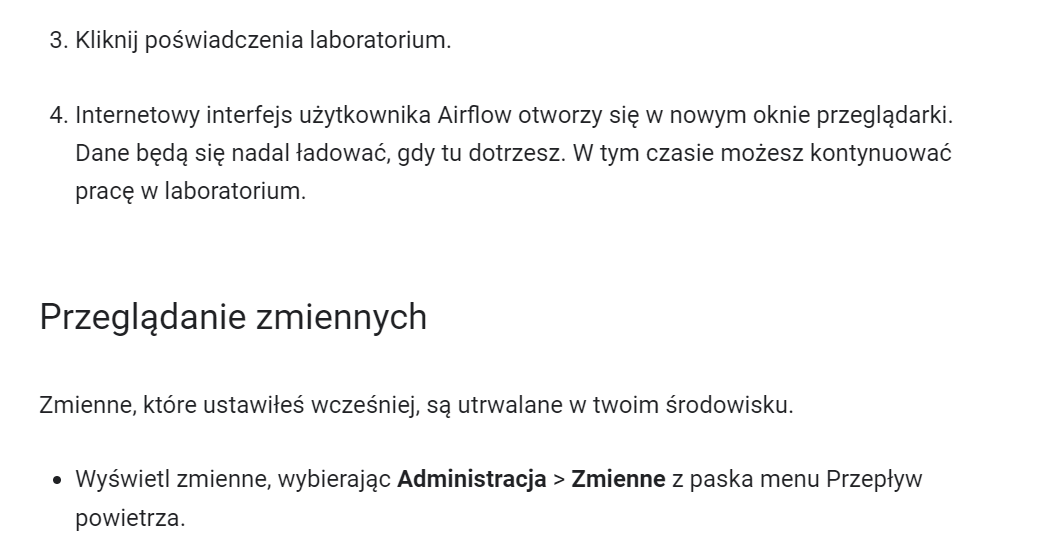

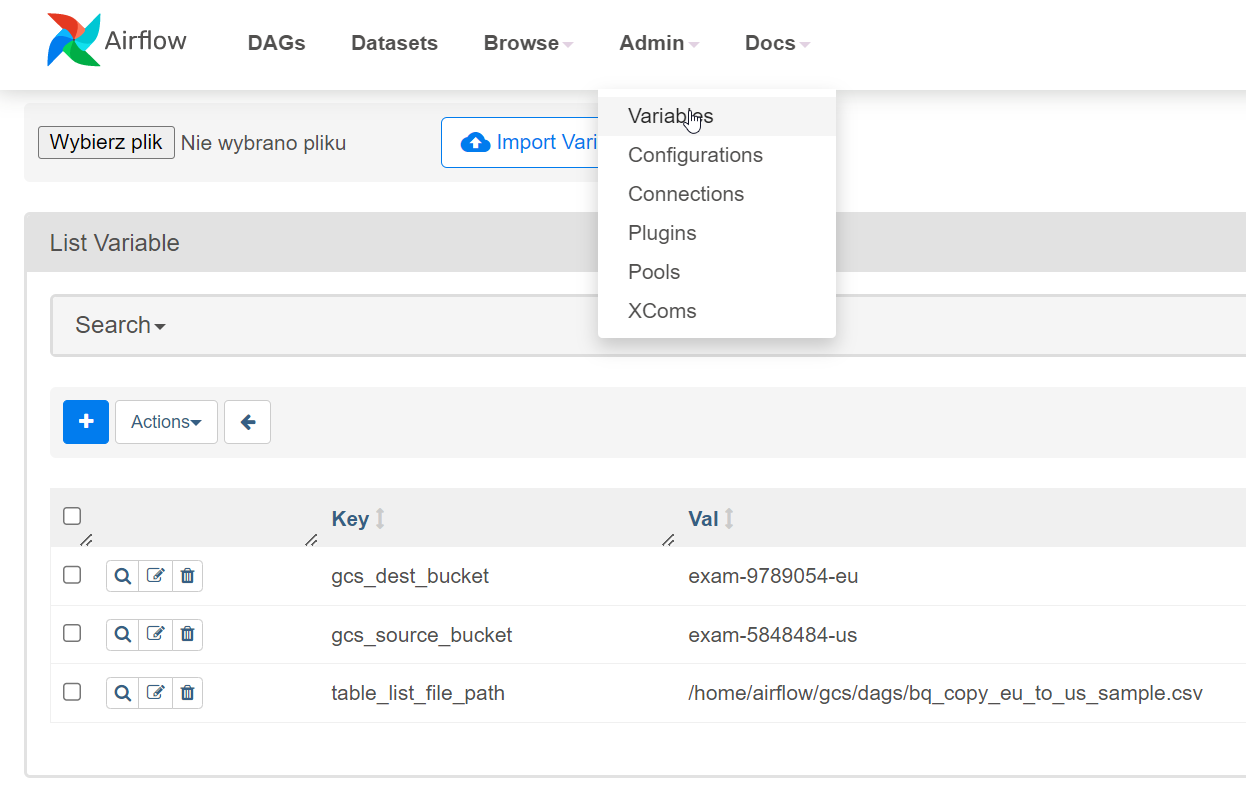

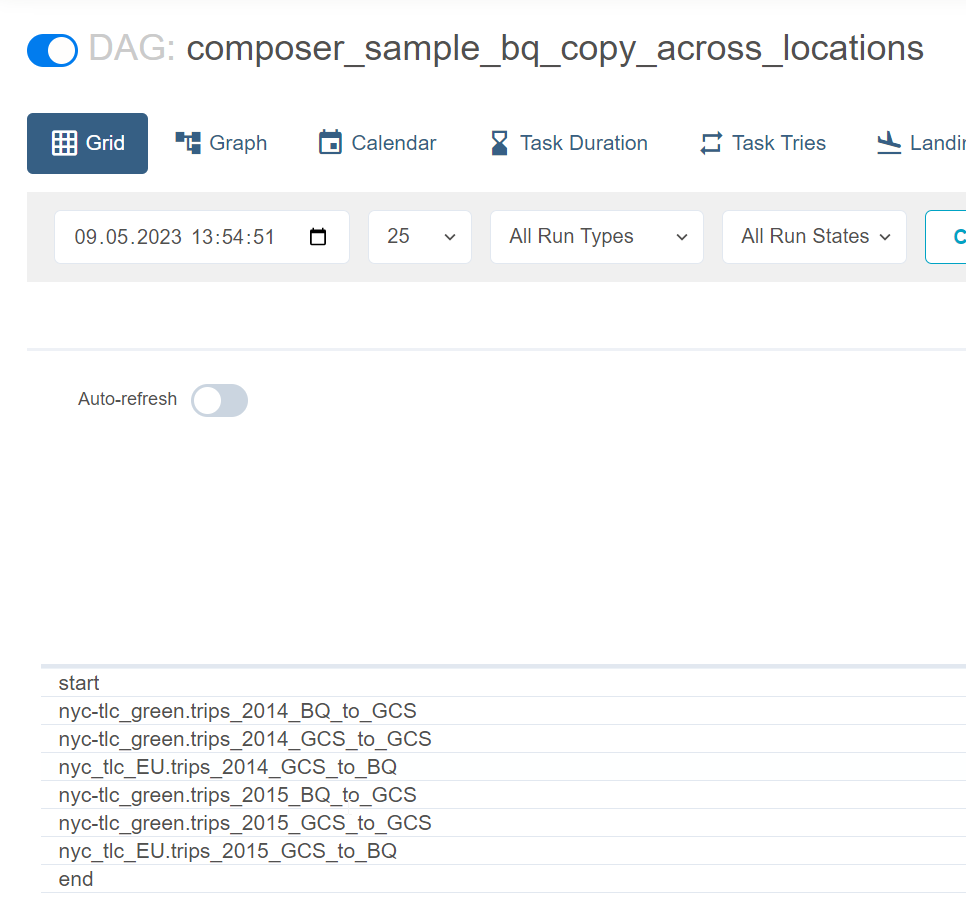

In [ ]:
# start

# nyc-tlc_green.trips_2014_BQ_to_GCS

# nyc-tlc_green.trips_2014_GCS_to_GCS

# nyc_tlc_EU.trips_2014_GCS_to_BQ

# nyc-tlc_green.trips_2015_BQ_to_GCS

# nyc-tlc_green.trips_2015_GCS_to_GCS

# nyc_tlc_EU.trips_2015_GCS_to_BQ

# end

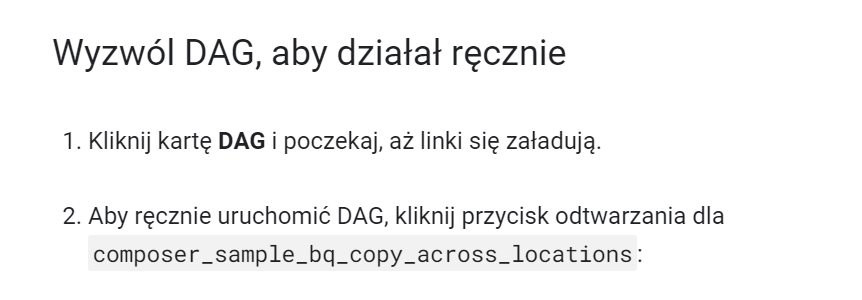

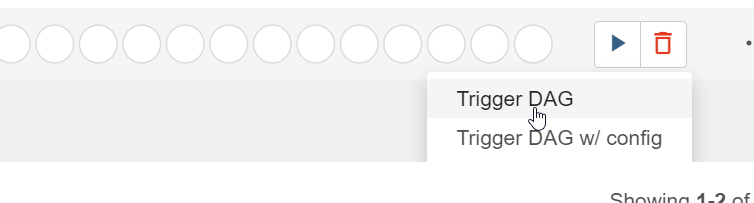

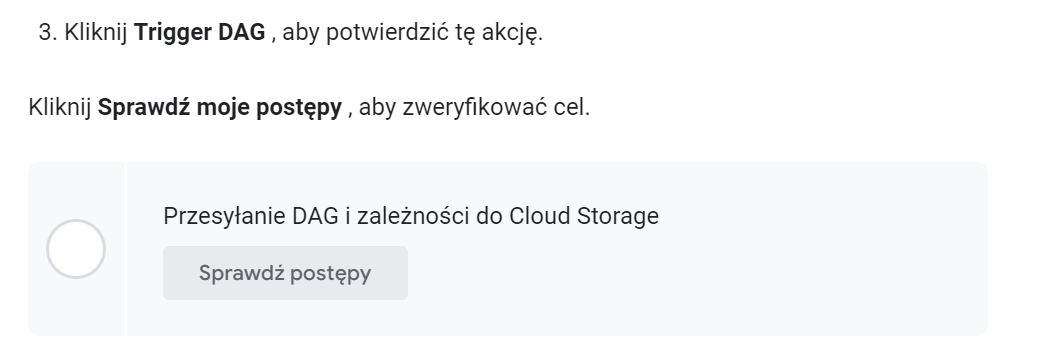

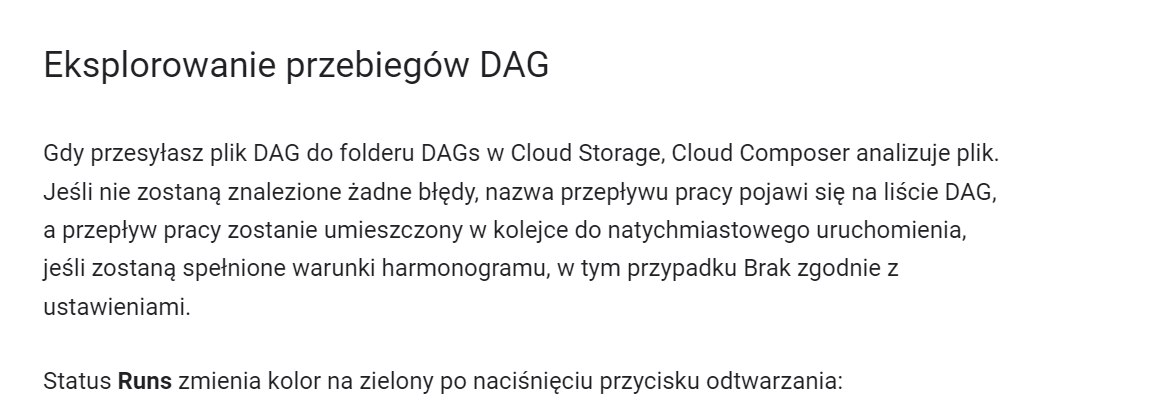

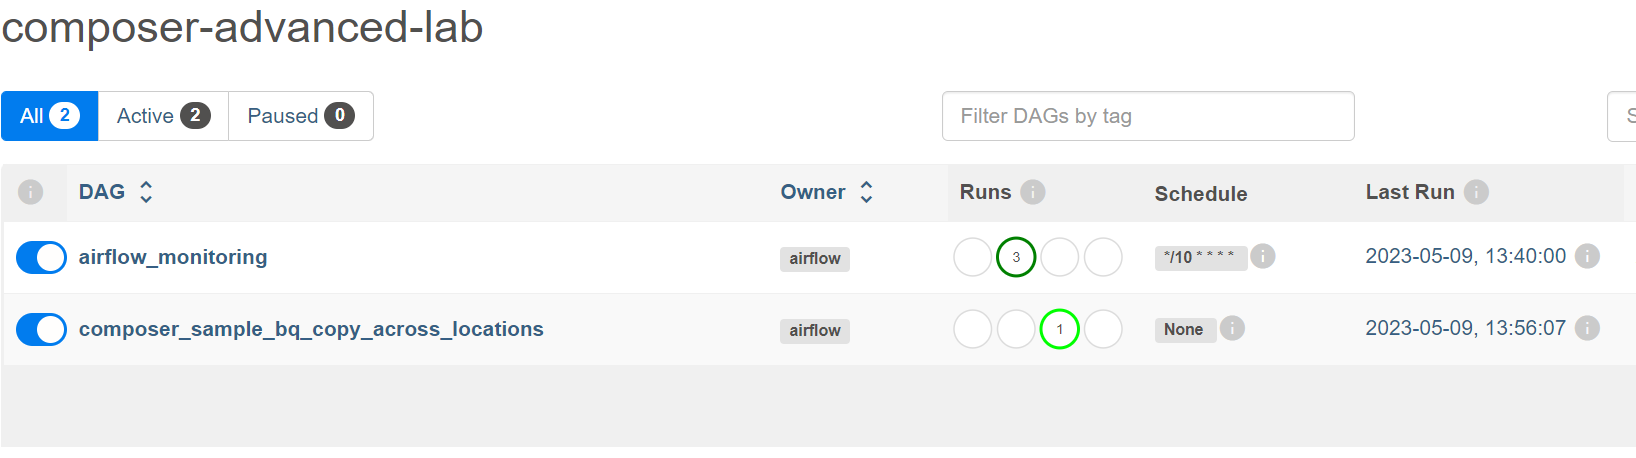

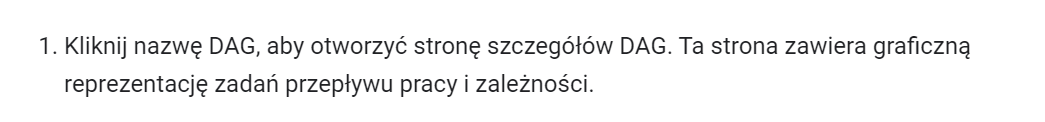

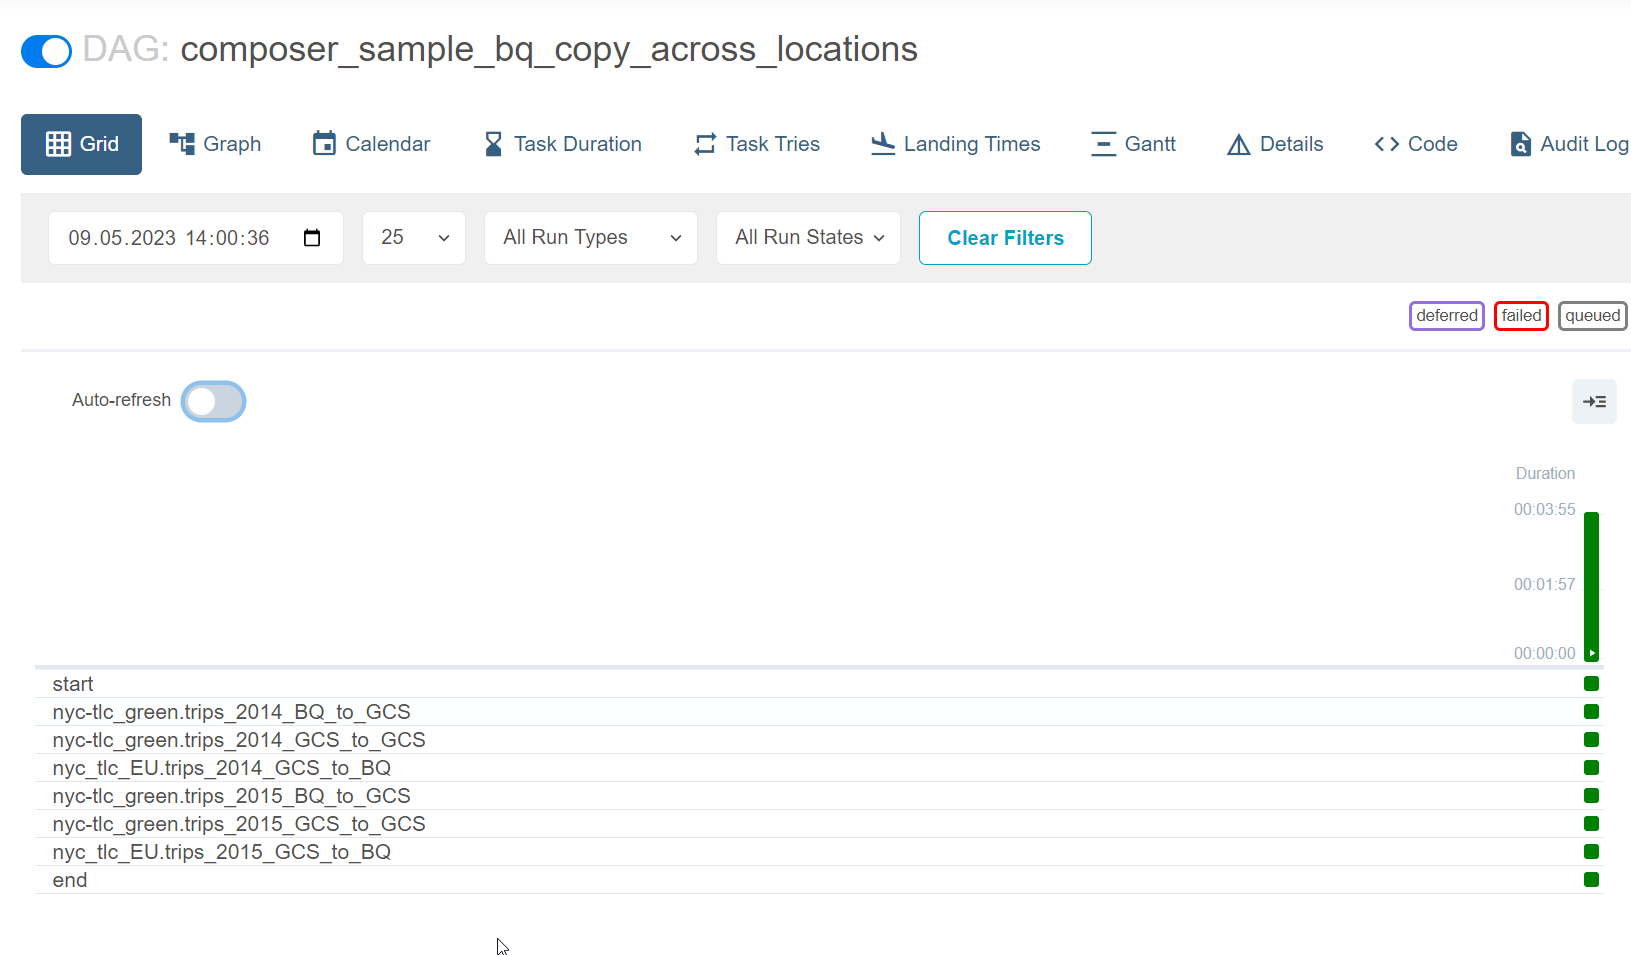

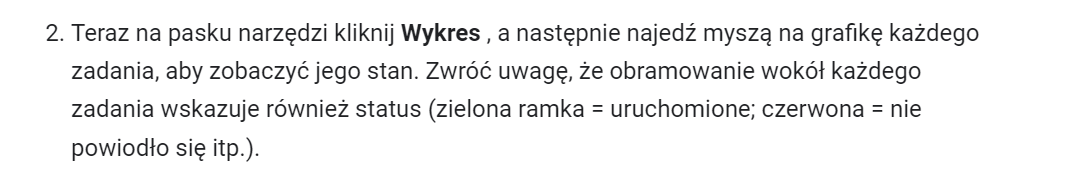

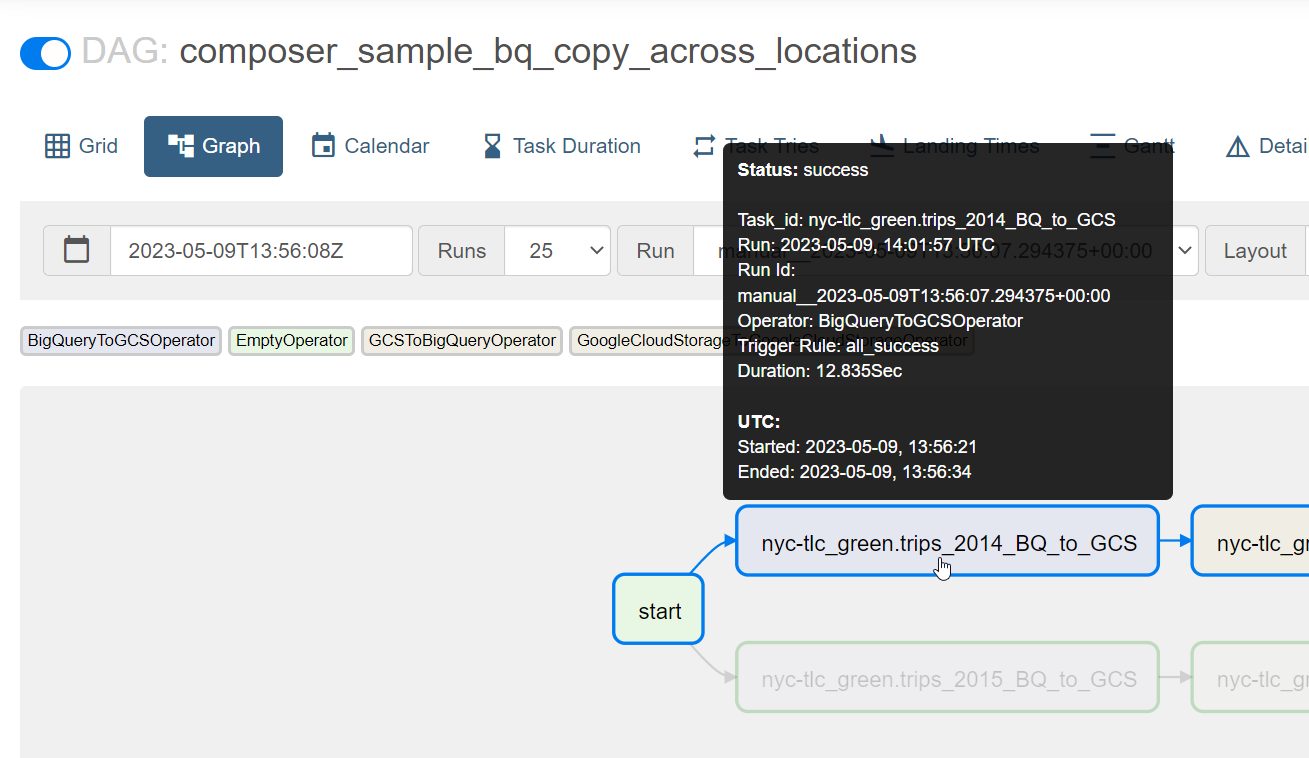

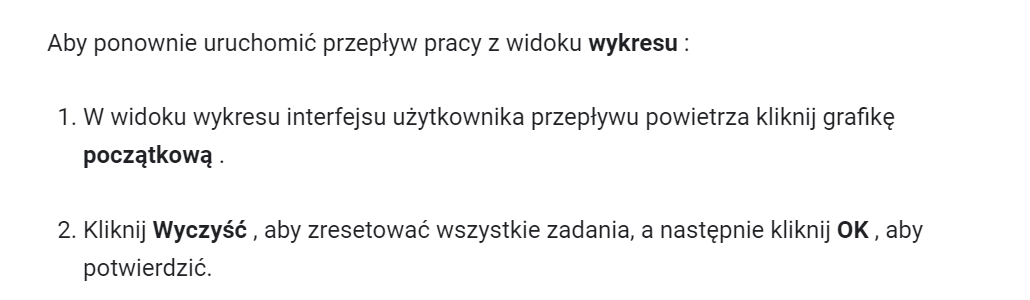

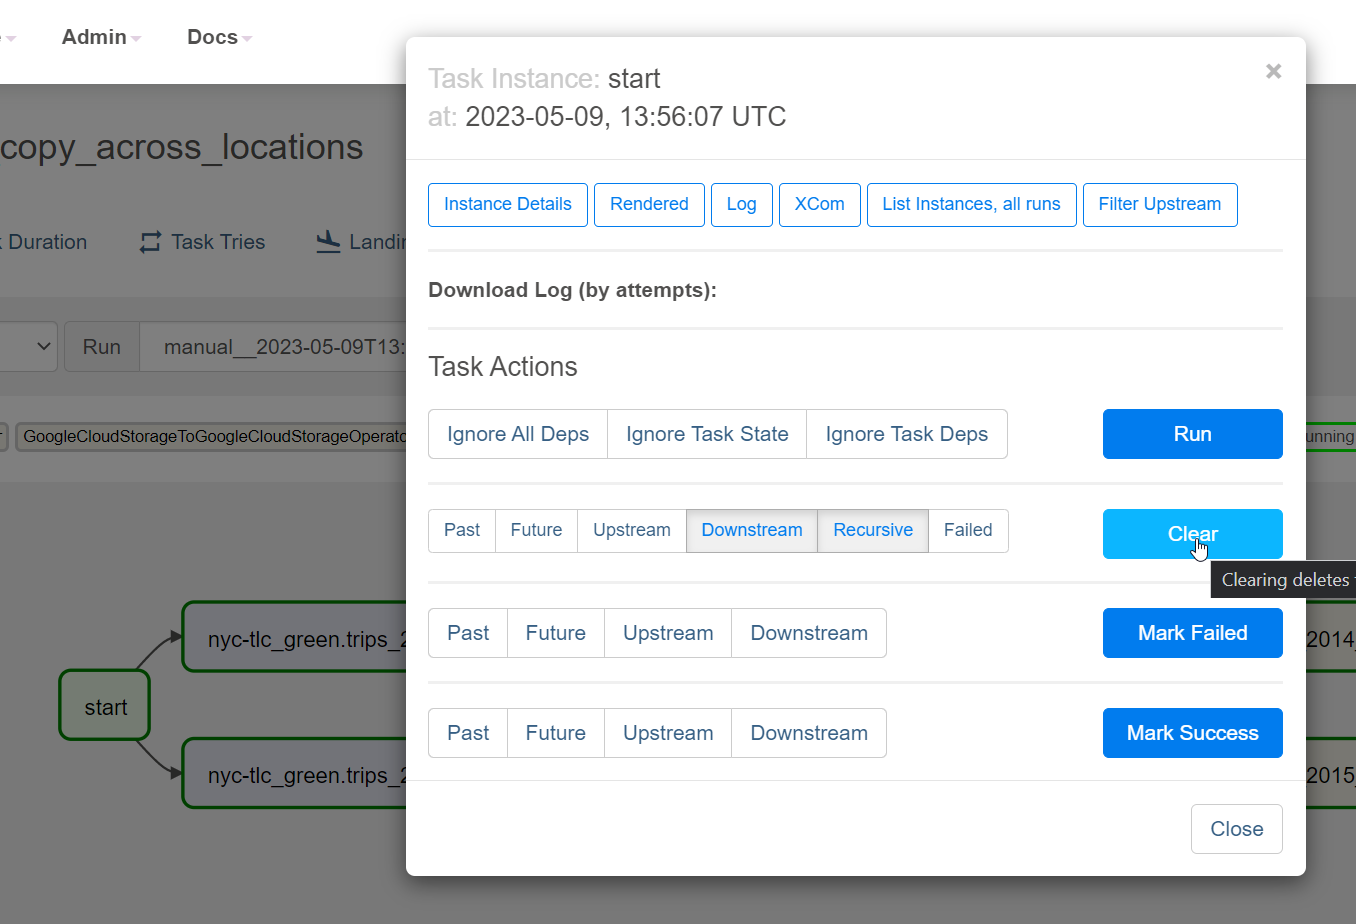

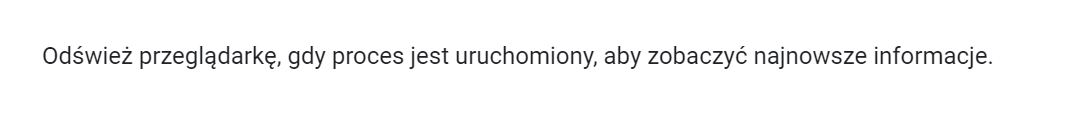

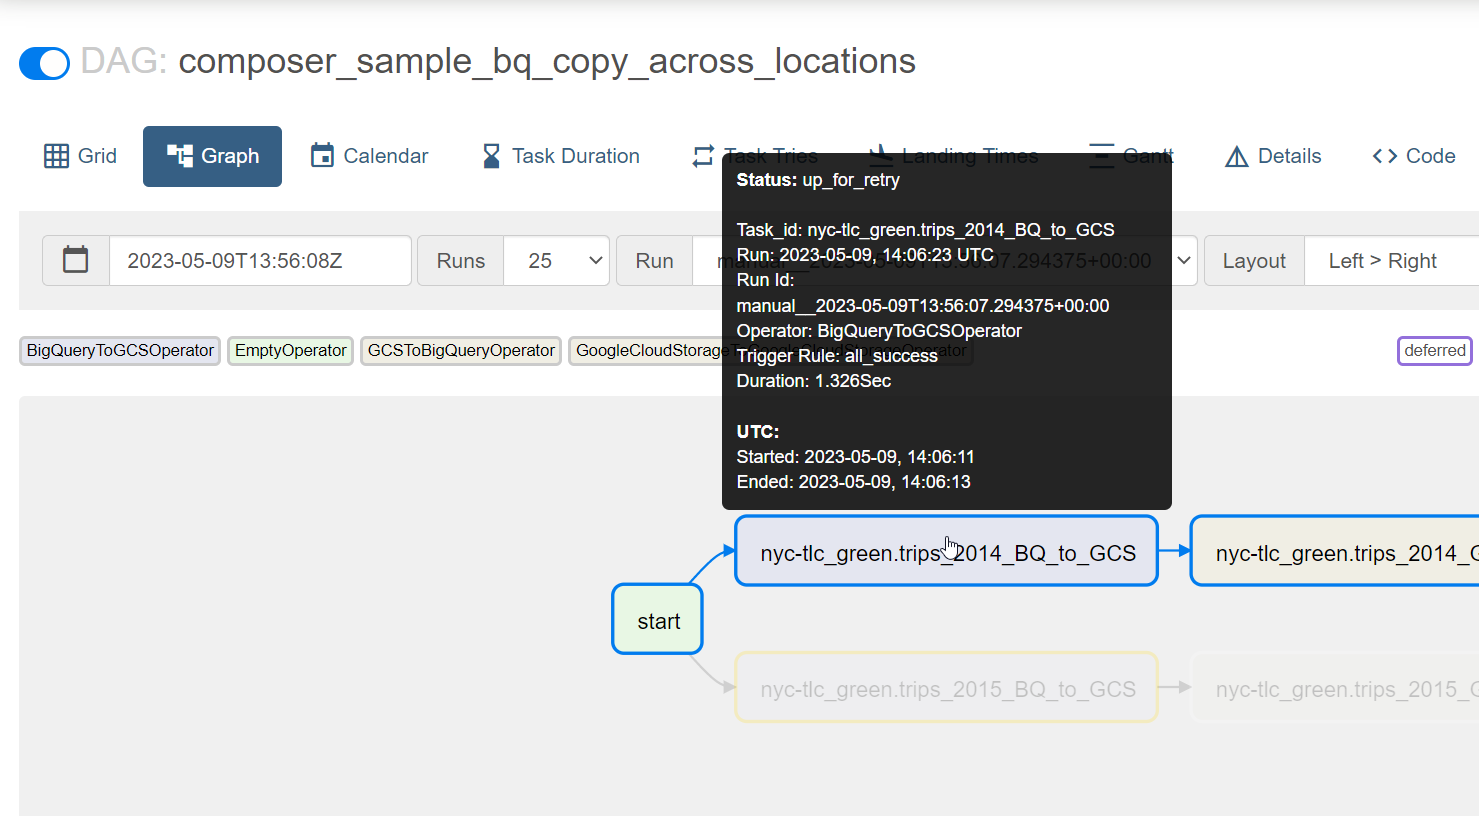

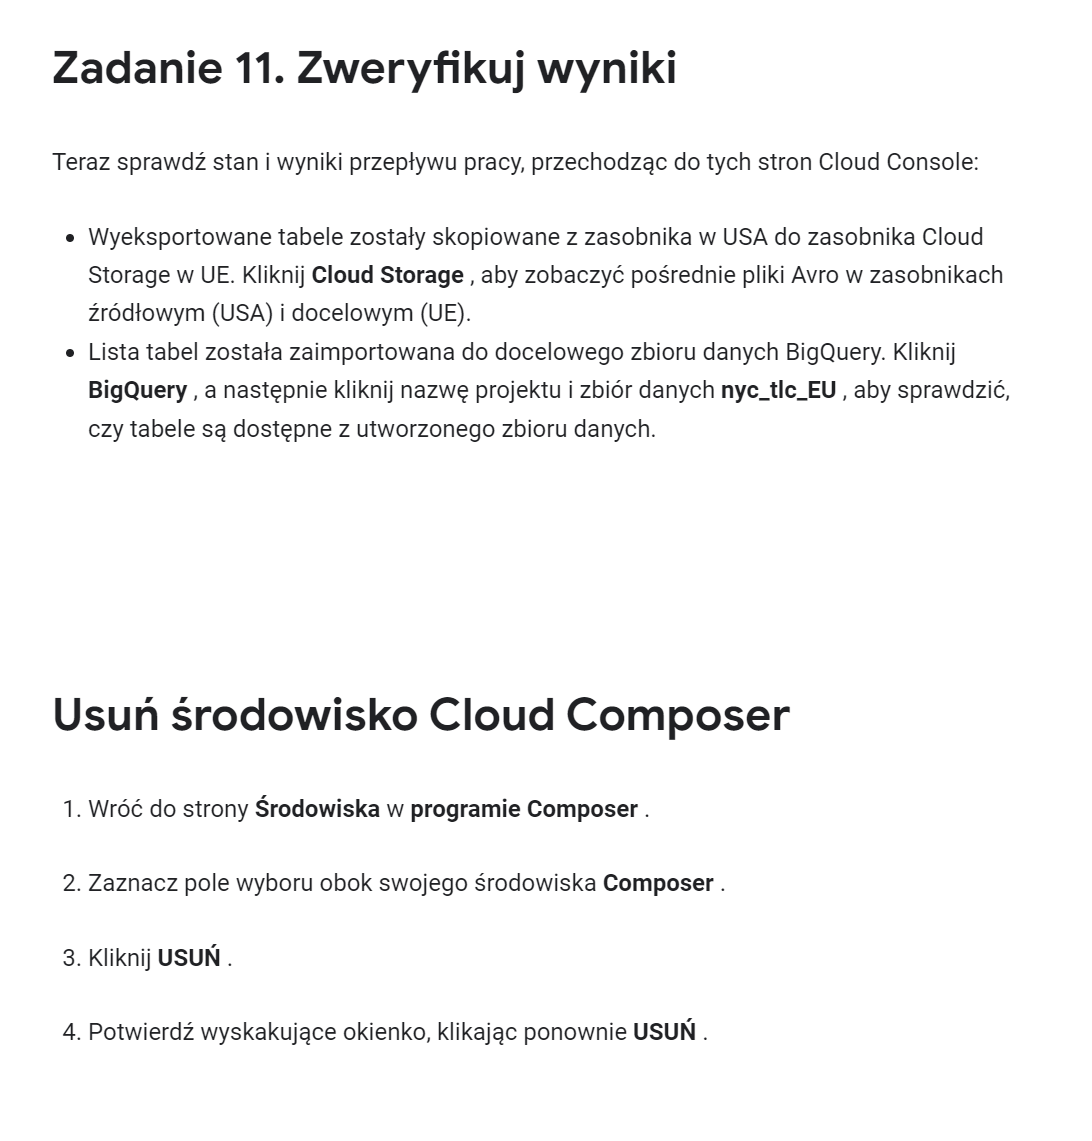

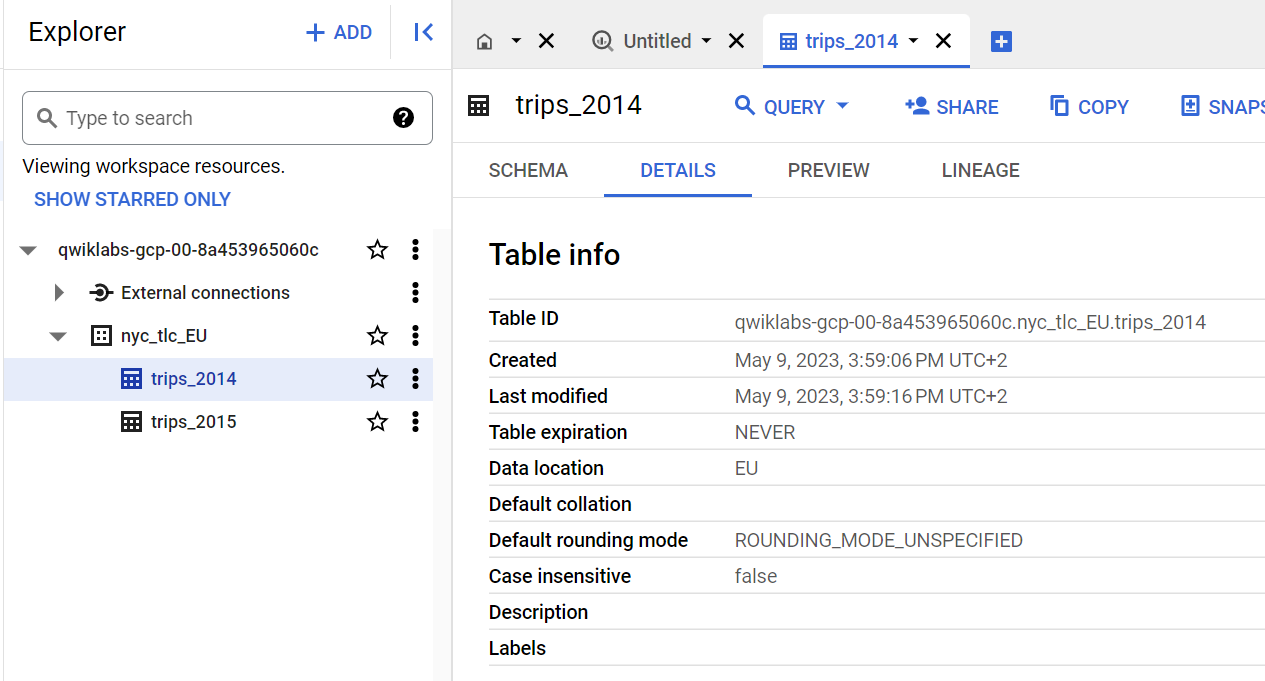